In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras, time, sys, os, gc

DTYPE_OP = 'float32'
keras.backend.set_floatx(DTYPE_OP)

if DTYPE_OP == 'float64':
    keras.backend.set_epsilon(np.finfo(np.float64).eps)
elif DTYPE_OP == 'float32':
    keras.backend.set_epsilon(np.finfo(np.float32).eps)
    

from sklearn.preprocessing import StandardScaler
from code.MixtureofGroups import project_and_cluster,clusterize_annotators
from code.MixtureofGroups import *

from code.baseline import LabelInference
from code.representation import *
from code.utils import *

Using TensorFlow backend.


### CIFAR-10 Test set
https://sites.google.com/site/hophuoctien/projects/virec/cifar10-classification

> Tien Ho-Phuoc, CIFAR10 to Compare Visual Recognition Performance between Deep Neural Networks and Humans, arXiv, 2018

In [2]:
from keras.datasets import cifar10
(_, _), (X_test, Z_test) = cifar10.load_data()
Z_test = Z_test[:,0]
N = X_test.shape[0]
print("Input shape:",X_test.shape)

Input shape: (10000, 32, 32, 3)


In [7]:
folder = "../New_CIFAR_test/"

In [8]:
from scipy.io import loadmat
#aux = loadmat(folder+"CIFAR10_EasySubset.mat")
aux = loadmat(folder+"CIFAR10_HumanRecogData.mat")
aux = aux["expData"][0][0][0]
T = 60 #60 annotations
y_obs = np.ones((N,T),dtype='int16')*-1
for annotation in aux:
    ann_id = annotation[0]-1
    cifar_indx = annotation[1]-1
    ann = annotation[2]-1
    y_obs[cifar_indx,ann_id] = ann

T_weights = np.sum(y_obs != -1,axis=0) #distribucion de anotaciones

K = np.max(y_obs)+1 # asumiendo que estan ordenadas

y_obs_categorical = set_representation(y_obs,'onehot') #for raykar
print("shape:",y_obs_categorical.shape)

shape: (10000, 60, 10)


Every data has 6 annotations, every annotator annotate 1000 data, T_weights = 1000, T_weights norm = 1/T

Bayesian gaussian mixture say is 5 clusters 
DBSCAN say is 5 clusters
Affinity Propagation say is 3 clusters


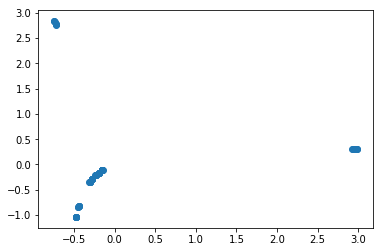

ACC MV on train: 0.9757
Normalized entropy (0-1) of repeats annotations: 0.05247443779676492


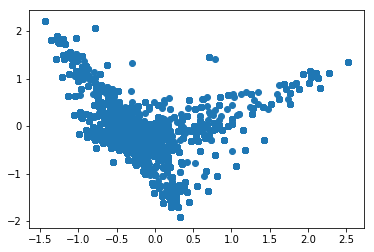

In [5]:
annotators_pca = project_and_cluster(y_obs_categorical,DTYPE_OP=DTYPE_OP,mode_project='pca')[0]
std = StandardScaler(with_mean=True,with_std=True)
annotators_pca2 = std.fit_transform(annotators_pca)
plt.scatter(annotators_pca2[:,0],annotators_pca2[:,1])
plt.show()

label_I = LabelInference(y_obs,1,type_inf = 'mv')
mv_onehot = label_I.mv_labels('classes')
print("ACC MV on train:",np.mean(mv_onehot==Z_test))

mv_soft = majority_voting(label_I.y_obs_repeat,repeats=True,probas=True) 
aux = []
for example in mv_soft:
    aux.append(entropy(example)/np.log(K))
print("Normalized entropy (0-1) of repeats annotations:",np.mean(aux))

predicted = np.clip(mv_soft, keras.backend.epsilon(), 1.)
data_to_cluster = []
for i in range(mv_soft.shape[0]):
    for j in range(mv_soft.shape[1]):
        ob = np.tile(keras.backend.epsilon(), mv_soft.shape[1])
        ob[j] = 1
        true = np.clip(predicted[i],keras.backend.epsilon(),1.)      
        f_l = distance_function(true, ob)  #funcion de distancia o similaridad
        data_to_cluster.append(f_l)  
data_to_cluster = np.asarray(data_to_cluster)
model = PCA(n_components=min(3,mv_soft.shape[0]) ) 
data_to_cluster = model.fit_transform(data_to_cluster)

std = StandardScaler(with_mean=True,with_std=True)
data_to_plot = std.fit_transform(data_to_cluster)
plt.scatter(data_to_plot[:,0],data_to_plot[:,1])
plt.show()

It look like there is a presence of groups...

### Fashion 10000
---
https://es.slideshare.net/mriegler/f10000  
dbgroup.cs.tsinghua.edu.cn/ligl/crowddata/  

> Fashion 10000: An Enriched Social Image Dataset for Fashion and Clothing


Q6: formal?

In [28]:
folder = "../Fashion10000/Annotations/"

In [29]:
df_ann = pd.read_csv(folder+"MTurk_NonExperts_Results.csv")
for i in range(1,5): #add photo id to extract image
    new_column = []
    for pic_url in df_ann["Input.Url"+str(i)].values:
        process = pic_url.split("/")[-1].split("_")[0] #extraer el id...
        new_column.append(int(process))
    df_ann["PHOTO_ID"+str(i)] = new_column
df_ann.head()

,HITId,HITTypeId,Title,Description,Keywords,Reward,CreationTime,MaxAssignments,RequesterAnnotation,AssignmentDurationInSeconds,...,Answer.specialty3,Answer.specialty4,Answer.type1,Answer.type2,Answer.type3,Answer.type4,PHOTO_ID1,PHOTO_ID2,PHOTO_ID3,PHOTO_ID4
0,2BUF806UFBNFSU6QHDU9BSW83V41F0,2QKNDWIOV1S7SMT9PEL19YDZ81JIXX,Check images of clothing items and fashion acc...,In this HIT we show you 4 images and we want t...,"fashion, image annotation, clothing, image, ta...",$0.09,Tue Jun 25 17:00:45 GMT 2013,3,BatchId:1189029;,900,...,No,No,notapp,notapp,yes,yes,3147969538,3504068315,3533130703,3533131723
1,2BUF806UFBNFSU6QHDU9BSW83V41F0,2QKNDWIOV1S7SMT9PEL19YDZ81JIXX,Check images of clothing items and fashion acc...,In this HIT we show you 4 images and we want t...,"fashion, image annotation, clothing, image, ta...",$0.09,Tue Jun 25 17:00:45 GMT 2013,3,BatchId:1189029;,900,...,No,No,notapp,notapp,no,no,3147969538,3504068315,3533130703,3533131723
2,2BUF806UFBNFSU6QHDU9BSW83V41F0,2QKNDWIOV1S7SMT9PEL19YDZ81JIXX,Check images of clothing items and fashion acc...,In this HIT we show you 4 images and we want t...,"fashion, image annotation, clothing, image, ta...",$0.09,Tue Jun 25 17:00:45 GMT 2013,3,BatchId:1189029;,900,...,No,NotSure,noperson,noperson,notapp,notapp,3147969538,3504068315,3533130703,3533131723
3,2I3Y58B727M0IF5GDBS64FSXVJZAVM,2QKNDWIOV1S7SMT9PEL19YDZ81JIXX,Check images of clothing items and fashion acc...,In this HIT we show you 4 images and we want t...,"fashion, image annotation, clothing, image, ta...",$0.09,Tue Jun 25 17:00:45 GMT 2013,3,BatchId:1189029;,900,...,No,No,noperson,noperson,no,noperson,5805025859,5829762711,6115511126,6308843053
4,2I3Y58B727M0IF5GDBS64FSXVJZAVM,2QKNDWIOV1S7SMT9PEL19YDZ81JIXX,Check images of clothing items and fashion acc...,In this HIT we show you 4 images and we want t...,"fashion, image annotation, clothing, image, ta...",$0.09,Tue Jun 25 17:00:45 GMT 2013,3,BatchId:1189029;,900,...,No,No,noperson,noperson,yes,noperson,5805025859,5829762711,6115511126,6308843053


In [84]:
#photos ids distintas
photo_ids = {}
for i in range(1,5):
    for value in df_ann["PHOTO_ID"+str(i)].values:
        if value in photo_ids:
            photo_ids[value] +=1
        else:
            photo_ids[value] = 1 #counts

idx_ann =  {value:i for i,value in enumerate(df_ann["WorkerIndex"].unique())}
num_data = {value:i for i,value in enumerate(list(photo_ids.keys())) }

N = len(num_data)
T = len(idx_ann)

#which answer take
aux = df_ann["Answer.type1"].unique()
label_names = aux[~pd.isna(aux)]
classes = {value.lower():i for i,value in enumerate(label_names)}
classes[np.nan] = -1
classes

{nan: -1, 'no': 3, 'noperson': 1, 'notapp': 0, 'yes': 2}

In [83]:
df["Majority Q4"].unique()

array(['notapp', nan, 'noperson', 'no', 'yes'], dtype=object)

Data with GT:  (27105,)


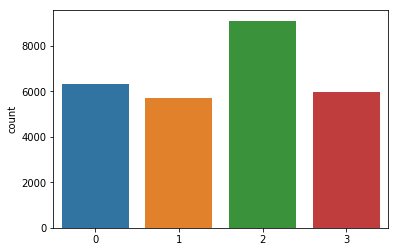

In [85]:
#probabbly ground truth
df = pd.read_csv(folder+"Annotation_PerImage_All.csv") 
new_column = []
for dato in df.values:
    pic_url = dato[0] #picture url
    process = pic_url.split("/")[-1].split("_")[0] #extraer el id...
    new_column.append(int(process))
df["PHOTO_ID"] = new_column

Z_data = np.ones((N,),dtype='int16')*-1
for i in range(df.shape[0]):
    row = df.iloc[i]
    #Majority Q6 is formal
    if classes[row["Majority Q4"]]!=-1: #only data that majority is reached
        Z_data[num_data[row["PHOTO_ID"]]] = classes[row["Majority Q4"]]

mask_gt = Z_data != -1
Z_data = Z_data[mask_gt] #data with gt
print("Data with GT: ",Z_data.shape)
sns.countplot(Z_data)

In [86]:
y_obs = np.ones((N,T),dtype='int16')*-1
for i in range(df_ann.shape[0]):
    row = df_ann.iloc[i]
    ann_id = idx_ann[row["WorkerIndex"]]
    for j in range(1,4+1):
        fashion_indx = num_data[row["PHOTO_ID"+str(j)]]
        try:
            ann = classes[row["Answer.type"+str(j)]] #which we are using?
        except:
            ann = classes[row["Answer.type"+str(j)].lower()] #which we are using?
        y_obs[fashion_indx,ann_id] = ann
        
T_weights = np.sum(y_obs != -1,axis=0) #distribucion de anotaciones

print("Remove %d annotators that do not annotate on this set "%(np.sum(T_weights==0)))
y_obs = y_obs[:,T_weights!=0]
T_weights = np.sum(y_obs != -1,axis=0) #distribucion de anotaciones

K = np.max(y_obs)+1 # asumiendo que estan ordenadas

print("shape:",y_obs.shape)
y_obs

Remove 17 annotators that do not annotate on this set 
shape: (31077, 1453)


array([[-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       ...,
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1]], dtype=int16)

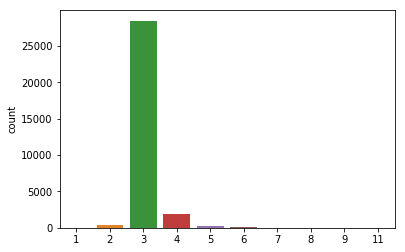

Minimum annotations in a example:  1
Maximum annotations in a example:  11
T data (expected value):  3.0731409080670593
Graphics of T weights


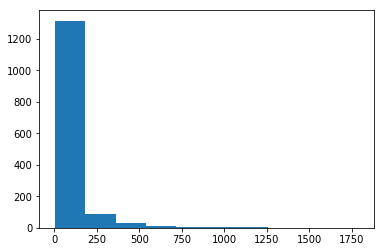

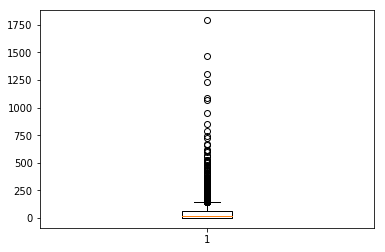

Minimum annotations by an annotator:  1
Maximum annotations by an annotator:  1792
Mean annotations by an annotator:  65.5934065934066


In [46]:
#graphics and distribution? what is T_data
N_ann = np.sum(y_obs != -1,axis=1) #distribucion de anotaciones con este valor

sns.countplot(N_ann)
plt.show()
print("Minimum annotations in a example: ",N_ann.min())
print("Maximum annotations in a example: ",N_ann.max())
print("T data (expected value): ",N_ann.mean())

print("Graphics of T weights")
plt.hist(T_weights)
plt.show()

plt.boxplot(T_weights)
plt.show()
print("Minimum annotations by an annotator: ",T_weights.min())
print("Maximum annotations by an annotator: ",T_weights.max())
print("Mean annotations by an annotator: ",T_weights.mean())

Representation for MV in 1.857044 sec
Estimation MV in 0.002568 sec
ACC MV on train: 0.9935067330750784
Normalized entropy (0-1) of repeats annotations: 0.3535304070935552


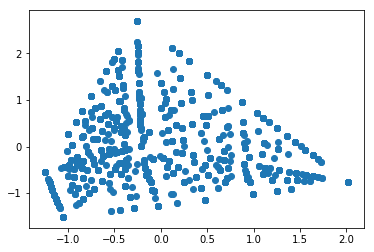

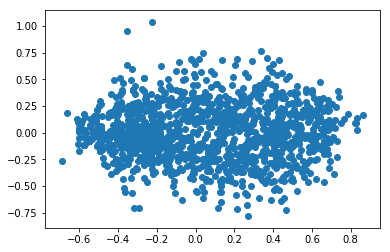

In [87]:
label_I = LabelInference(y_obs,1,type_inf = 'mv')
mv_onehot, _ = label_I.mv_labels('classes')
print("ACC MV on train:",np.mean(mv_onehot[mask_gt]==Z_data))

mv_soft = majority_voting(label_I.y_obs_repeat,repeats=True,probas=True) 
aux = []
for example in mv_soft:
    aux.append(entropy(example)/np.log(K))
print("Normalized entropy (0-1) of repeats annotations:",np.mean(aux))


predicted = np.clip(mv_soft, keras.backend.epsilon(), 1.)
data_to_cluster = []
for i in range(mv_soft.shape[0]):
    for j in range(mv_soft.shape[1]):
        ob = np.tile(keras.backend.epsilon(), mv_soft.shape[1])
        ob[j] = 1
        true = np.clip(predicted[i],keras.backend.epsilon(),1.)      
        f_l = distance_function(true, ob)  #funcion de distancia o similaridad
        data_to_cluster.append(f_l)  
data_to_cluster = np.asarray(data_to_cluster)
model = PCA(n_components=min(3,mv_soft.shape[0]) ) 
data_to_cluster = model.fit_transform(data_to_cluster)

std = StandardScaler(with_mean=True,with_std=True)
data_to_plot = std.fit_transform(data_to_cluster)
plt.scatter(data_to_plot[:,0],data_to_plot[:,1])
plt.show()


Y_ann_train, T_idx = set_representation(y_obs,"onehotvar")
from code.MixtureofGroups import *
conf_mat, conf_mat_norm  = build_conf_Yvar(Y_ann_train, T_idx, mv_soft.argmax(axis=-1))

A_rep = conf_mat_norm.reshape(conf_mat_norm.shape[0], K**2) #flatten

from sklearn.decomposition import PCA
model = PCA(2)
aux_pca = model.fit_transform(A_rep)
plt.scatter(aux_pca[:,0],aux_pca[:,1])
plt.show()

It does not look promesing that contain groups...

### GalaxyZoo
---
to download images: https://astroquery.readthedocs.io/en/latest/sdss/sdss.html  
annot data: https://data.galaxyzoo.org/  
Kaggle data: https://www.kaggle.com/c/galaxy-zoo-the-galaxy-challenge  

In [4]:
folder ="../GalaxyZoo_kaggle/"
train_labels = pd.read_csv(folder+"train_labels.csv")
test_labels = pd.read_csv(folder+"test_labels.csv")
print(train_labels.shape)
train_labels.head()

(50000, 38)


,GalaxyID,Answer1.1,Answer1.2,Answer1.3,Answer2.1,Answer2.2,Answer3.1,Answer3.2,Answer4.1,Answer4.2,...,Answer9.3,Answer10.1,Answer10.2,Answer10.3,Answer11.1,Answer11.2,Answer11.3,Answer11.4,Answer11.5,Answer11.6
0,569297,0.083065,0.916935,0.000000,0.023551,0.893384,0.107109,0.786276,0.714189,0.179195,...,0.000000,0.459257,0.254932,0.000000,0.000000,0.504446,0.000000,0.0,0.0,0.209744
1,701332,0.275109,0.713127,0.011765,0.633523,0.079604,0.079604,0.000000,0.000000,0.079604,...,0.499005,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
2,908039,0.411643,0.587223,0.001134,0.234878,0.352345,0.000000,0.352345,0.205471,0.146874,...,0.026647,0.205471,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.205471
3,401459,0.013316,0.986684,0.000000,0.000000,0.986684,0.753419,0.233265,0.986684,0.000000,...,0.000000,0.350273,0.381847,0.254564,0.191225,0.508621,0.095613,0.0,0.0,0.191225
4,607293,0.829407,0.128859,0.041733,0.021519,0.107340,0.000000,0.107340,0.000000,0.107340,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000


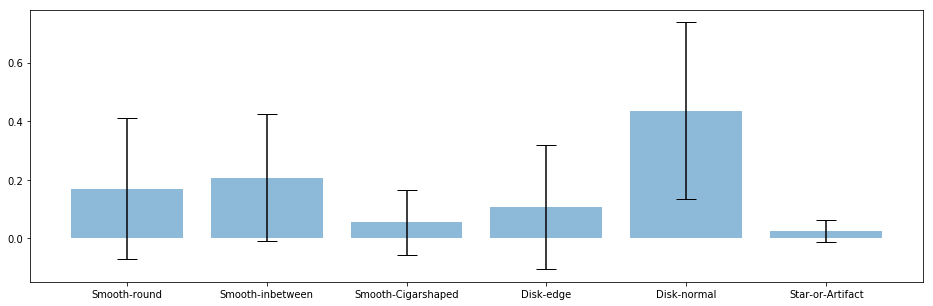

In [6]:
labels = ["Smooth-round","Smooth-inbetween","Smooth-Cigarshaped","Disk-edge","Disk-normal","Star-or-Artifact"]

columns = ["Answer7.1","Answer7.2","Answer7.3","Answer2.1","Answer2.2","Answer1.3"]
y_train = train_labels.loc[:,columns].values
y_test = test_labels.loc[:,columns].values

plt.figure(figsize=(16,5))
plt.bar(np.arange(y_train.shape[1]),np.mean(y_train,axis=0), yerr=np.std(y_train,axis=0),alpha=0.5,capsize=10)
plt.xticks(np.arange(y_train.shape[1]),labels)
plt.show()

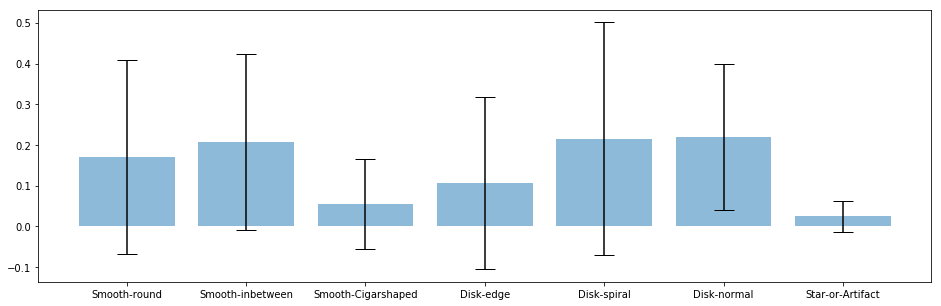

In [11]:
#granulada
labels = ["Smooth-round","Smooth-inbetween","Smooth-Cigarshaped","Disk-edge","Disk-spiral","Disk-normal","Star-or-Artifact"]

columns = ["Answer7.1","Answer7.2","Answer7.3","Answer2.1","Answer4.1","Answer4.2","Answer1.3"]
y_train = train_labels.loc[:,columns].values
y_test = test_labels.loc[:,columns].values

plt.figure(figsize=(16,5))
plt.bar(np.arange(y_train.shape[1]),np.mean(y_train,axis=0), yerr=np.std(y_train,axis=0),alpha=0.5,capsize=10)
plt.xticks(np.arange(y_train.shape[1]),labels)
plt.show()

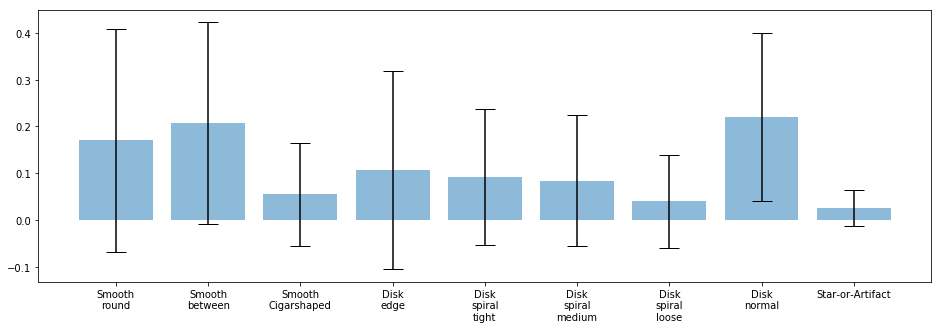

In [13]:
#mas granulada
labels = ["Smooth\nround","Smooth\nbetween","Smooth\nCigarshaped","Disk\nedge","Disk\nspiral\ntight","Disk\nspiral\nmedium","Disk\nspiral\nloose","Disk\nnormal","Star-or-Artifact"]

columns = ["Answer7.1","Answer7.2","Answer7.3","Answer2.1","Answer10.1","Answer10.2","Answer10.3","Answer4.2","Answer1.3"]
y_train = train_labels.loc[:,columns].values
y_test = test_labels.loc[:,columns].values

plt.figure(figsize=(16,5))
plt.bar(np.arange(y_train.shape[1]),np.mean(y_train,axis=0), yerr=np.std(y_train,axis=0),alpha=0.5,capsize=10)
plt.xticks(np.arange(y_train.shape[1]),labels)
plt.show()

In [58]:
aux = pd.read_csv(folder+"/GalaxyZoo1_DR_table3.csv.gz")
print(aux.shape)
print("T_data=",np.mean(aux["NVOTE"]))
print("max(T_data)=",np.max(aux["NVOTE"]))
print("min(T_data)=",np.min(aux["NVOTE"]))
aux.head()

(225268, 11)
T_data= 38.74157891933164
max(T_data)= 93
min(T_data)= 7


,OBJID,RA,DEC,NVOTE,P_EL,P_CW,P_ACW,P_EDGE,P_DK,P_MG,P_CS
0,587730774425665700,00:00:01.28,+15:04:40.8,73,0.479,0.000,0.000,0.014,0.479,0.027,0.014
1,587727220876640877,00:00:01.86,+14:01:28.2,29,0.655,0.000,0.000,0.000,0.345,0.000,0.000
2,587727180060098742,00:00:02.15,-09:31:37.0,30,0.467,0.000,0.033,0.000,0.467,0.033,0.033
3,588015509806252142,00:00:02.28,+00:37:39.2,29,0.655,0.034,0.034,0.103,0.172,0.000,0.172
4,587731187277627683,00:00:02.96,+00:43:04.8,24,0.583,0.000,0.083,0.167,0.125,0.042,0.250


In [59]:
#T is aprox 100 000
T_data = 39
r_obs = y_train*T_data  #assuming 39 annotations by data -- maybe sampling..
r_obs = np.round(r_obs).astype('int')

K = r_obs.shape[1]
N = r_obs.shape[0]

print("repeats shape: ",r_obs.shape)
print("Classes: ",K)

repeats shape:  (50000, 9)
Classes:  9


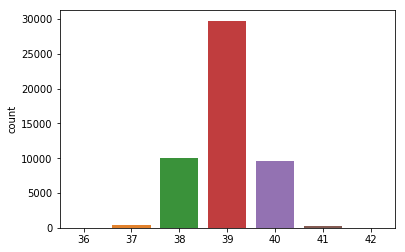

Minimum annotations in a example:  36
Maximum annotations in a example:  42
T data (expected value):  38.98852


In [60]:
#graphics and distribution? what is T_data
N_ann = np.sum(r_obs,axis=1) #distribucion de anotaciones con este valor

sns.countplot(N_ann)
plt.show()
print("Minimum annotations in a example: ",N_ann.min())
print("Maximum annotations in a example: ",N_ann.max())
print("T data (expected value): ",N_ann.mean())

Normalized entropy (0-1) of repeats annotations: 0.5286125459892007


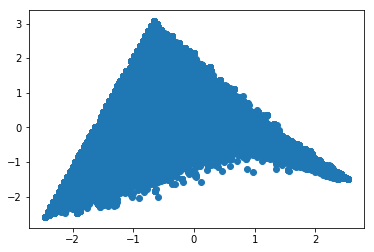

In [61]:
mv_soft = majority_voting(r_obs,repeats=True,probas=True) 
aux = []
for example in mv_soft:
    aux.append(entropy(example)/np.log(K))
print("Normalized entropy (0-1) of repeats annotations:",np.mean(aux))

predicted = np.clip(mv_soft, keras.backend.epsilon(), 1.)
data_to_cluster = []
for i in range(mv_soft.shape[0]):
    for j in range(mv_soft.shape[1]):
        ob = np.tile(keras.backend.epsilon(), mv_soft.shape[1])
        ob[j] = 1
        true = np.clip(predicted[i],keras.backend.epsilon(),1.)      
        f_l = distance_function(true, ob)  #funcion de distancia o similaridad
        data_to_cluster.append(f_l)  
data_to_cluster = np.asarray(data_to_cluster)
model = PCA(n_components=min(3,mv_soft.shape[0]) ) 
data_to_cluster = model.fit_transform(data_to_cluster)

std = StandardScaler(with_mean=True,with_std=True)
data_to_plot = std.fit_transform(data_to_cluster)
plt.scatter(data_to_plot[:,0],data_to_plot[:,1])
plt.show()

due to the density of annotations there is a chance that there are groups presented or maybe discovered..

### NER MTurk
---

cómo representar "X"

In [2]:
folder = "../Probar/20_dataArchive/"

df1 = pd.read_csv(folder+"/ner_mturk/mturk/Batch_213638_result.csv") 
df2 = pd.read_csv(folder+"/ner_mturk/mturk/Batch_229788_result.csv") 
df3 = pd.read_csv(folder+"/ner_mturk/mturk/Batch_230657_result.csv") 
df = pd.concat([df1,df2,df3],axis=0,ignore_index=True)
print(df.shape)
print(df["Description"][0])
df.head()

/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (170,171,172,182,187,188,189,190,191,194,195,197,199,201,203,205,206,207,209,210,211,212,214,215,216,217,218,219,220,221,222,224,225,227,229,230,233,235,236,237,239,240,242,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,261,262,263,264,265,266,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (254,255,281,339,340,341,343,344,345,346,349,350,351,354,355,356,357,358) have mixed types. Specify

(6160, 364)
Given a Twitter status message, select words that refer to people, places, and organizations.


,AcceptTime,Answer.TID1,Answer.TID2,Answer.TID3,Answer.TID4,Answer.TID5,Answer.browserInfo,Answer.city,Answer.country,Answer.ipAddress,...,NumberOfSimilarHITs,Reject,RejectionTime,RequesterAnnotation,RequesterFeedback,Reward,SubmitTime,Title,WorkTimeInSeconds,WorkerId
0,Fri Mar 26 07:00:48 GMT 2010,115512,115647,117353,1386721,114959,Mozilla/5.0 (Windows; U; Windows NT 5.1; en-US...,Seattle,United States,NaN,...,133,NaN,NaN,NaN,NaN,$0.05,Fri Mar 26 07:01:04 GMT 2010,Label named entities in Twitter data,16,AL8CK436OAAS
1,Fri Mar 26 07:07:13 GMT 2010,115512,115647,117353,1386721,114959,Mozilla/5.0 (Windows; U; Windows NT 5.1; en-US...,Mesa,United States,NaN,...,133,NaN,NaN,NaN,NaN,$0.05,Fri Mar 26 07:07:32 GMT 2010,Label named entities in Twitter data,19,A2IUEI1BFHCVBR
2,Thu Mar 25 22:48:12 GMT 2010,953212,115683,114681,115457,115780,NaN,NaN,NaN,NaN,...,244,NaN,NaN,NaN,NaN,$0.05,Thu Mar 25 22:48:30 GMT 2010,Label named entities in Twitter data,18,AN81OMLNG792S
3,Fri Mar 26 02:04:23 GMT 2010,953212,115683,114681,115457,115780,Mozilla/5.0 (Windows; U; Windows NT 6.0; en-US...,Spokane,United States,NaN,...,244,NaN,NaN,NaN,NaN,$0.05,Fri Mar 26 02:05:34 GMT 2010,Label named entities in Twitter data,71,A9Y7WSKEUTLSG
4,Fri Mar 26 07:51:00 GMT 2010,116704,1299720,115461,114494,115261,Mozilla/5.0 (Windows; U; Windows NT 5.1; en-US...,Salem,India,NaN,...,11,NaN,NaN,NaN,NaN,$0.05,Fri Mar 26 07:51:57 GMT 2010,Label named entities in Twitter data,57,ARUUP1I9I765J


In [3]:
worker2ind = {value:i for i,value in enumerate(df["WorkerId"].unique())}
T = len(list(worker2ind.values()))
id_data = set(df["Answer.TID1"]) | set(df["Answer.TID2"]) | set(df["Answer.TID3"]) | set(df["Answer.TID4"]) | set(df["Answer.TID5"])

answers = np.ones((len(id_data),T),dtype='int16')*-1
answers

array([[-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       ...,
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1]], dtype=int16)

In [4]:
import ast 

In [28]:
worker2ind

{'A108MS9X4JQ31C': 192,
 'A10GFVUN24Q71V': 248,
 'A11XA5JEXPZ0KU': 53,
 'A122B7AN31VJLB': 103,
 'A12CJNE0B9FLK8': 137,
 'A12LJL2ESEI6Y5': 77,
 'A131N3IB2F9DNJ': 95,
 'A146V5EFMA15XB': 34,
 'A14WWG6NKBDWGP': 166,
 'A153QSGVGLWKR6': 218,
 'A15Z06PIDEJT38': 59,
 'A16C1JJWHEU02G': 239,
 'A171JY5QWKQR8X': 102,
 'A17QLPGYGPYSQI': 66,
 'A17R8JHE5H8SYH': 114,
 'A17V9UJOCSM3OF': 68,
 'A18SOP2YLC0HZN': 193,
 'A18WWWZ1HRBG0V': 84,
 'A198YDDSSOBP8A': 238,
 'A19I5GDQ2AL0HF': 18,
 'A19MOSX3XM0PEY': 188,
 'A19OOK4MQ6RKIP': 8,
 'A19P6Q6PRNNJPZ': 127,
 'A19X7JVVC3CZMZ': 31,
 'A1A5QGCFNSF75G': 51,
 'A1B4J1HUDTQ5J0': 52,
 'A1B72GLF6DS21Y': 257,
 'A1BLX6S1YBA7Y8': 219,
 'A1BOPXWO3VOVZL': 148,
 'A1BPG9BBLYPIAD': 23,
 'A1CCJXYEMTU2RR': 185,
 'A1D67BJW63N47G': 172,
 'A1E61YLCV0PDFU': 235,
 'A1F0WAU8ZNOJFT': 213,
 'A1FAASLGTOMXO9': 241,
 'A1FP00QXS43PZ': 126,
 'A1FS5EXKNSINCF': 232,
 'A1G4NBA96061F3': 94,
 'A1GISOQV9E61KD': 43,
 'A1GRZQJP0NUN3Y': 17,
 'A1H0X3XRHYZ3XQ': 110,
 'A1H35C0LXHFR1M': 64,
 'A1H6SYVQAN

In [94]:
def sub_find(data,lista):
    aux = []
    for value in lista:
        if data in value and "unsure" not in value:
            aux.append(value)
    return aux
columns = list(df.columns)

train_texts = {value:0 for value in id_data}
answers_dic = {value:[] for value in id_data}
for i in range(df.shape[0]):
    id_worker = worker2ind[df.loc[i,"WorkerId"]]
    for k in range(0,5):
        id_aux = df.loc[i,"Answer.TID"+str(k+1)]
        if train_texts[id_aux] == 0:
            train_texts[id_aux] = ast.literal_eval(df.loc[i,"Input.tweet"+str(k)])
        len_i = len(train_texts[id_aux])
        
        if len(answers_dic[id_aux]) == 0:
            answers_dic[id_aux] = np.asarray([ ["?"]*T ]*len_i,dtype='object')
        
        aux_list = []
        for i_d in range(len_i):
            #palabra para un tweet
            #print( answers_dic[id_aux][i_d])
            if not pd.isna(df.loc[i,"Answer.tweet"+str(k)+"word"+str(i_d)]):
                answers_dic[id_aux][i_d,id_worker] = df.loc[i,"Answer.tweet"+str(k)+"word"+str(i_d)]
            #y si ya tiene?
            

In [95]:
X_train_texts = list(train_texts.values())
answers = list(answers_dic.values())

In [49]:
X_train_texts[1]

['Analysis:',
 "Obama''s",
 'centrist',
 'emphasis',
 'gives',
 'GOP',
 'ammo',
 '\\n',
 '(AP)\\n:',
 'AP',
 '-',
 'Is',
 'Barack',
 'Obama',
 'close',
 'to',
 'being',
 'shadowed',
 'by',
 'giant',
 'flip-flops',
 '',
 '',
 '']

In [57]:
answers[1]

array([['?', '?', '?', ..., '?', '?', '?'],
       ['?', '?', '?', ..., '?', '?', '?'],
       ['?', '?', '?', ..., '?', '?', '?'],
       ...,
       ['?', '?', '?', ..., '?', '?', '?'],
       ['?', '?', '?', ..., '?', '?', '?'],
       ['?', '?', '?', ..., '?', '?', '?']], dtype=object)

In [83]:
labels
label2ind = {label: (index) for index, label in enumerate(labels)}
ind2label = {(index): label for index, label in enumerate(labels)}
label2ind

{'none': 0, 'org': 1, 'person': 2, 'place': 3}

In [92]:
for dato in answers:
    for palabra in dato:
        for annotation in palabra:
            if pd.isna(annotation):
                print("Hay")

Hay
Hay
Hay
Hay
Hay
Hay
Hay
Hay
Hay
Hay


KeyboardInterrupt: 

In [96]:
y_obs = np.asarray([ [label2ind[annotation] if annotation != "?" else -1 for annotation in palabra] for dato in answers for palabra in dato])
N,T = y_obs.shape
print(N,T)
y_obs

205282 269


array([[-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       ...,
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1]])

In [58]:
df_g = pd.read_csv(folder+"/ner_mturk/inputs/Gold.csv") 
print(df_g.shape)
df_g.head()

(441, 82)


,HITId,HITTypeId,Title,Description,Keywords,Reward,CreationTime,MaxAssignments,RequesterAnnotation,AssignmentDurationInSeconds,...,Answer.word28,Answer.unsure4,Answer.word29,Answer.unsure6,Answer.unsure15,Answer.unsure9,Answer.unsure19,Answer.unsure20,Approve,Reject
0,1V9S0WR1Y69H2PA0OW1VNI62NNMD5T,1PG4GVIAJYO5H8LCGDJNWKIN3TOVTG,Label named entities in Twitter data,"Given a Twitter status message, select words t...","twitter, named entity",$0.01,Thu Mar 18 01:39:47 GMT 2010,1,NaN,600,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1P0UL3JPGT3HCPSUWLRFEJ9IOFFAME,1PG4GVIAJYO5H8LCGDJNWKIN3TOVTG,Label named entities in Twitter data,"Given a Twitter status message, select words t...","twitter, named entity",$0.01,Thu Mar 18 01:39:47 GMT 2010,1,NaN,600,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1F84T485IRVF6BM7RY9T4TJFDKAFS8,1PG4GVIAJYO5H8LCGDJNWKIN3TOVTG,Label named entities in Twitter data,"Given a Twitter status message, select words t...","twitter, named entity",$0.01,Thu Mar 18 01:39:47 GMT 2010,1,NaN,600,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,16QPTX5PKYSX67A9W9Q0E6UTOAPALC,1PG4GVIAJYO5H8LCGDJNWKIN3TOVTG,Label named entities in Twitter data,"Given a Twitter status message, select words t...","twitter, named entity",$0.01,Thu Mar 18 01:39:47 GMT 2010,1,NaN,600,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,170HZD1E9YM18Z3OQHRJSPSI2OUA4J,1PG4GVIAJYO5H8LCGDJNWKIN3TOVTG,Label named entities in Twitter data,"Given a Twitter status message, select words t...","twitter, named entity",$0.01,Thu Mar 18 01:39:44 GMT 2010,1,NaN,600,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [81]:
test_texts = {value:0 for value in df_g["Answer.TID"].unique()}
test_gt = {value:0 for value in df_g["Answer.TID"].unique()}
labels = []
for i in range(df_g.shape[0]):
    id_aux = df_g.loc[i,"Answer.TID"]
    train_texts[id_aux] = ast.literal_eval(df_g.loc[i,"Input.json_words"])
        
    len_i = len(train_texts[id_aux])
    
    if test_gt[id_aux] == 0:
        test_gt[id_aux] = ["?"]*len_i

    aux_list = []
    for i_d in range(len_i):
        try:
            test_gt[id_aux][i_d] = df_g.loc[i,"Answer.word"+str(i_d)]
            if test_gt[id_aux][i_d] not in labels:
                labels.append(test_gt[id_aux][i_d])
        except:
             pass #unsure..
       

In [100]:
Z_test = np.asarray([label2ind[value] for lista in test_gt.values() for value in lista ])
Z_test.shape

(7037,)

In [101]:
Z_test

array([0, 0, 0, ..., 0, 0, 0])

In [102]:
label2ind

{'none': 0, 'org': 1, 'person': 2, 'place': 3}

In [84]:
def read_conll(filename):
    raw = open(filename, 'r').readlines()
    all_x = []
    point = []
    for line in raw:
        stripped_line = line.strip().split(' ')
        point.append(stripped_line)
        if line == '\n':
            if len(point[:-1]) > 0:
                all_x.append(point[:-1])
            point = []
    all_x = all_x
    return all_x

folder = "../Deep Learning from Crowds/ner-mturk/"

all_answers = read_conll(folder+'answers.txt') #annotations
all_ground_truth = read_conll(folder+'ground_truth.txt')

all_test = read_conll(folder+'testset.txt')
all_docs = all_ground_truth + all_test

print("Answers data size:", len(all_answers))
print("Ground truth data size:", len(all_ground_truth))
print("Test data size:", len(all_test))
print("Total sequences:", len(all_docs))

Answers data size: 5985
Ground truth data size: 5985
Test data size: 3250
Total sequences: 9235


In [124]:
X_train_texts = [[c[0] for c in x] for x in all_answers]
y_answers = [[c[1:] for c in y] for y in all_answers]
y_ground_truth = [[c[1] for c in y] for y in all_ground_truth]
X_test_texts = [[c[0] for c in x] for x in all_test]
y_test = [[c[1] for c in y] for y in all_test]
#X_all = [[c[0] for c in x] for x in all_docs]
#y_all = [[c[1] for c in y] for y in all_docs]

N_ANNOT = len(y_answers[0][0])
print("Num annnotators:", N_ANNOT)

lengths = [len(x) for x in all_docs]
all_text = [c for x in X_all for c in x]
words = list(set(all_text))
word2ind = {word: index for index, word in enumerate(words)}
ind2word = {index: word for index, word in enumerate(words)}
labels = list(set([c for x in y_all for c in x]))
print("Labels:", labels)
label2ind = {label: (index) for index, label in enumerate(labels)}
ind2label = {(index): label for index, label in enumerate(labels)}
#ind2label[0] = "O" # padding index
print('Input sequence length range: ', max(lengths), min(lengths))

max_label = max(label2ind.values()) + 1
print("Max label:", max_label)

maxlen = max([len(x) for x in X_all])
print('Maximum sequence length:', maxlen)

Num annnotators: 47
Labels: ['B-LOC', 'B-PER', 'B-ORG', 'O', 'I-ORG', 'B-MISC', 'I-MISC', 'I-PER', 'I-LOC']
Input sequence length range:  109 1
Max label: 9
Maximum sequence length: 109


In [99]:
X_all[:5]

[['Corporate', 'America', 'taking', 'new', 'view', 'on', 'compensation', '.'],
 ['Anne', 'Murray'],
 ['NEW', 'YORK', '1996-08-23'],
 ['Corporate',
  'America',
  'is',
  'planning',
  'major',
  'changes',
  'in',
  'employee',
  'compensation',
  'in',
  'the',
  'next',
  'few',
  'years',
  ',',
  'according',
  'to',
  'a',
  'recent',
  'study',
  '.'],
 ['What',
  'it',
  'comes',
  'down',
  'to',
  'is',
  'this',
  ':',
  'If',
  'you',
  "'re",
  'highly',
  'skilled',
  ',',
  'you',
  "'ll",
  'benefit',
  'nicely',
  '.']]

In [176]:
Z_train = np.asarray([label2ind[value] for lista in y_ground_truth for value in lista ])
Z_test = np.asarray([label2ind[value] for lista in y_test for value in lista ])
Z_train.shape

(79901,)

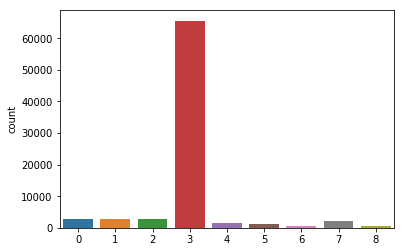

{0: 2929,
 1: 2808,
 2: 2779,
 3: 65546,
 4: 1544,
 5: 1343,
 6: 531,
 7: 1996,
 8: 425}

In [155]:
sns.countplot(Z_train)
plt.show()
unique, counts = np.unique(Z_train, return_counts=True)
dict(zip(unique, counts))

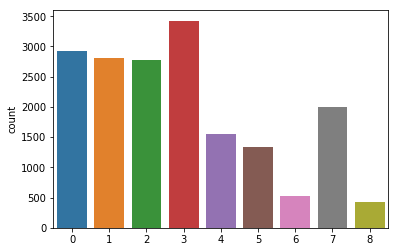

{0: 2929, 1: 2808, 2: 2779, 3: 3425, 4: 1544, 5: 1343, 6: 531, 7: 1996, 8: 425}

In [174]:
#delete "O" =?? o achicar la cantidad.. realizar lo mismos con test...
mask_notO = Z_train != 3
aux = np.random.choice(np.arange(Z_train.shape[0])[~mask_notO], 3500)

new_mask = mask_notO.copy()
new_mask[aux] = True #let 3000

sns.countplot(Z_train[new_mask])
plt.show()
unique, counts = np.unique(Z_train[new_mask], return_counts=True)
dict(zip(unique, counts))

In [157]:
y_obs = np.asarray([ [label2ind[annotation] if annotation != "?" else -1 for annotation in palabra] for dato in y_answers for palabra in dato])
N,T = y_obs.shape
print(N,T)
y_obs

79901 47


array([[ 3, -1, -1, ..., -1, -1,  3],
       [ 3, -1, -1, ..., -1, -1,  0],
       [ 3, -1, -1, ..., -1, -1,  3],
       ...,
       [-1, -1, -1, ..., -1, -1,  3],
       [-1, -1, -1, ..., -1, -1,  3],
       [-1, -1, -1, ..., -1, -1,  3]])

In [178]:
#aplied mask
Z_train = Z_train[new_mask]
y_obs = y_obs[new_mask]
N,T = y_obs.shape
print(N,T)

17780 47


array([[ 3, -1, -1, ..., -1, -1,  0],
       [ 1, -1, -1, ..., -1, -1,  3],
       [ 7, -1, -1, ..., -1, -1,  3],
       ...,
       [-1, -1, -1, ..., -1, -1,  1],
       [-1, -1, -1, ..., -1, -1,  3],
       [-1, -1, -1, ..., -1, -1,  3]])

In [ ]:
#how to build X??

In [102]:
X_train_enc = [[word2ind[c] for c in x] for x in X_train]
X_test_enc = [[word2ind[c] for c in x] for x in X_test]

NameError: name 'encode' is not defined

In [179]:
T_weights = np.sum(y_obs != -1,axis=0) #distribucion de anotaciones
K = np.max(y_obs)+1 # asumiendo que estan ordenadas

y_obs_categorical = set_representation(y_obs,'onehot') #for raykar
print("shape:",y_obs_categorical.shape)

shape: (17780, 47, 9)


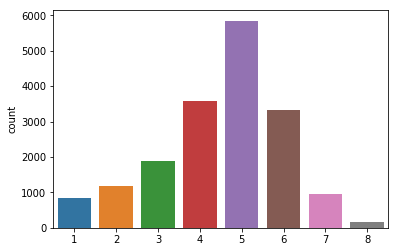

Minimum annotations in a example:  1
Maximum annotations in a example:  8
T data (expected value):  4.515466816647919
Graphics of T weights


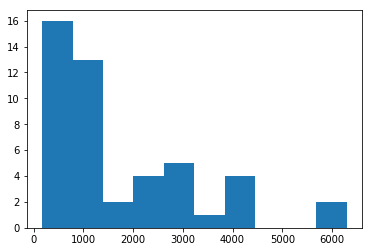

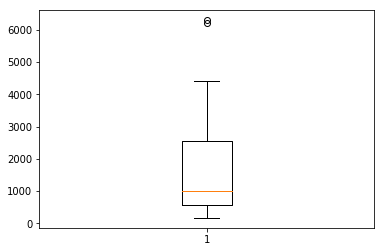

Minimum annotations by an annotator:  170
Maximum annotations by an annotator:  6293
Mean annotations by an annotator:  1708.1914893617022


In [180]:
#graphics and distribution? what is T_data
N_ann = np.sum(y_obs != -1,axis=1) #distribucion de anotaciones con este valor

sns.countplot(N_ann)
plt.show()
print("Minimum annotations in a example: ",N_ann.min())
print("Maximum annotations in a example: ",N_ann.max())
print("T data (expected value): ",N_ann.mean())

print("Graphics of T weights")
plt.hist(T_weights)
plt.show()

plt.boxplot(T_weights)
plt.show()
print("Minimum annotations by an annotator: ",T_weights.min())
print("Maximum annotations by an annotator: ",T_weights.max())
print("Mean annotations by an annotator: ",T_weights.mean())

Bayesian gaussian mixture say is 8 clusters 
DBSCAN say is 2 clusters
Affinity Propagation say is 1 clusters


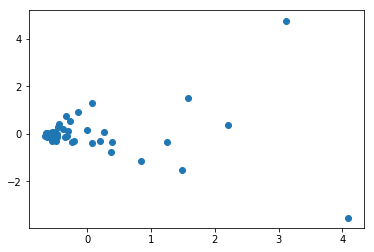

ACC MV on train: 0.6534308211473566
F1 MV on train: 0.6534308211473566
Normalized entropy (0-1) of repeats annotations: 0.19120196236851741


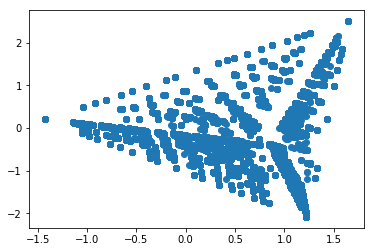

In [181]:
annotators_pca = project_and_cluster(y_obs_categorical,DTYPE_OP=DTYPE_OP,mode_project='pca')[0]
std = StandardScaler(with_mean=True,with_std=True)
annotators_pca2 = std.fit_transform(annotators_pca)
plt.scatter(annotators_pca2[:,0],annotators_pca2[:,1])
plt.show()

from sklearn.metrics import f1_score
label_I = LabelInference(y_obs,1,type_inf = 'mv')
mv_onehot = label_I.mv_labels('classes')
print("ACC MV on train:",np.mean(mv_onehot==Z_train))
print("F1 MV on train:",f1_score(Z_train,mv_onehot,average="micro"))


mv_soft = majority_voting(label_I.y_obs_repeat,repeats=True,probas=True) 
aux = []
for example in mv_soft:
    aux.append(entropy(example)/np.log(K))
print("Normalized entropy (0-1) of repeats annotations:",np.mean(aux))


predicted = np.clip(mv_soft, keras.backend.epsilon(), 1.)
data_to_cluster = []
for i in range(mv_soft.shape[0]):
    for j in range(mv_soft.shape[1]):
        ob = np.tile(keras.backend.epsilon(), mv_soft.shape[1])
        ob[j] = 1
        true = np.clip(predicted[i],keras.backend.epsilon(),1.)      
        f_l = distance_function(true, ob)  #funcion de distancia o similaridad
        data_to_cluster.append(f_l)  
data_to_cluster = np.asarray(data_to_cluster)
model = PCA(n_components=min(3,mv_soft.shape[0]) ) 
data_to_cluster = model.fit_transform(data_to_cluster)

std = StandardScaler(with_mean=True,with_std=True)
data_to_plot = std.fit_transform(data_to_cluster)
plt.scatter(data_to_plot[:,0],data_to_plot[:,1])
plt.show()

### Movie reviews
---
http://fprodrigues.com//publications/deep-crowds/
> Rodrigues, F., & Pereira, F. C. (2018, April). Deep learning from crowds. In Thirty-Second AAAI Conference on Artificial Intelligence. 

Necesario ver cómo discretizar..

In [3]:
folder = "../Deep Learning from Crowds/MovieReviews/"
def read_texts(filename):
    f = open(filename)
    data = [line.strip() for line in f]
    f.close()
    return data
texts_train = read_texts(folder+"texts_train.txt")
targets_train = np.loadtxt(folder+"ratings_train.txt")

texts_test = read_texts(folder+"texts_test.txt")
targets_test = np.loadtxt(folder+"ratings_test.txt")

print("Num. train texts: %d" % len(texts_train))
print("Num. test texts:  %d" % len(texts_test))

Num. train texts: 1498
Num. test texts:  3508


In [37]:
aux = pd.read_csv(folder+"Batch_results_AMT.csv") 
print(aux["Description"][0])
aux['WorkTimeInSeconds']

Given a short review text, predict the number of stars (from 0 to 10) that the movie got from that reviewer.


0          4
1         94
2         11
3         13
4          3
5         74
6          4
7         25
8          4
9          5
10        43
11         9
12         6
13         6
14         4
15        28
16         4
17         8
18         3
19         4
20         7
21         2
22         8
23         7
24         3
25        10
26        48
27         7
28        15
29         3
        ... 
7410       8
7411       6
7412      20
7413      48
7414       4
7415    1411
7416       6
7417      10
7418      15
7419       6
7420       3
7421       9
7422       3
7423       6
7424       6
7425       5
7426      20
7427       7
7428      30
7429       7
7430       4
7431      10
7432      16
7433      23
7434      61
7435       5
7436       5
7437       9
7438       7
7439       4
Name: WorkTimeInSeconds, Length: 7440, dtype: int64

(array([  7.,  40., 137., 206., 279., 251., 285., 183.,  97.,  13.]),
 array([0.05 , 0.145, 0.24 , 0.335, 0.43 , 0.525, 0.62 , 0.715, 0.81 ,
        0.905, 1.   ]),
 <a list of 10 Patch objects>)

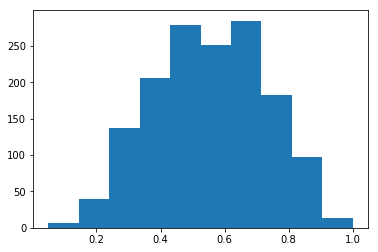

In [40]:
plt.hist(targets_train)

In [41]:
##stratified range..
limits = [0]
pos_values = np.unique(targets_train)

N = targets_train.shape[0]
splits = 5 #5 ,7,8
acum_split = []
data_by_split = N/(splits) #minimum data on split
print("Minimum data on split: ",data_by_split)

for i in range(splits-1):
    if i != len(limits)-1:
        break
    upper_values = pos_values[pos_values>=limits[i]]
    for value in upper_values: #find the upper limit
        range_v = (limits[i] <= targets_train ) & (targets_train < value)
        if np.sum(range_v) >= data_by_split:
            limits.append(value)
            acum_split.append(np.sum(range_v))
            break
range_v = (limits[-1] <= targets_train ) & (targets_train <=1)
limits.append(np.max(pos_values)+0.1)
acum_split.append(np.sum(range_v))
limits = np.asarray(limits)

print("Splits obtained: ",len(acum_split))
print("Splits obtained ammount: ",acum_split)
limits

Minimum data on split:  299.6
Splits obtained:  4
Splits obtained ammount:  [387, 303, 513, 295]


array([0.  , 0.41, 0.58, 0.71, 1.1 ])

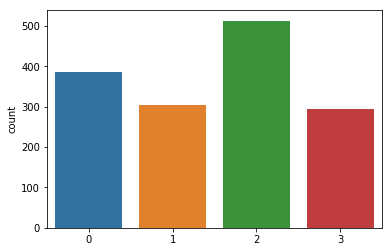

In [42]:
def continous_2_cat(data):
    if data == -1:
        return -1
    return np.where(limits <= data )[0][-1]

targets_train_cat = list(map(continous_2_cat,targets_train ))
targets_test_cat = list(map(continous_2_cat,targets_test ))
sns.countplot(targets_train_cat)


Label Decision 

The numerical ratings were derived from texts in the original html
files.  Note that with our particular conversion scheme, 0-to-4 stars
within a four star system translates into 0.1-to-0.9 in our normalized
numerical ratings, whereas 0-to-5 stars within a five star system
translates into 0-to-1.  (The reasoning was that in a four-star
system, an author is more likely to assign "endpoint" scores because
the dynamic range of the rating scheme is smaller.)
 
The class labels were then derived from the normalized numerical ratings.    
* for the three-class task: 
    * 0: rating <= 0.4
    * 1: 0.4 < rating < 0.7
    * 2: rating >= 0.7

* for the four-class task: 
    *    0: rating <=.3
    *    1: .4 <= rating <=.5
    *    2: .6 <= rating <= .7
    *    3: .8 <= rating


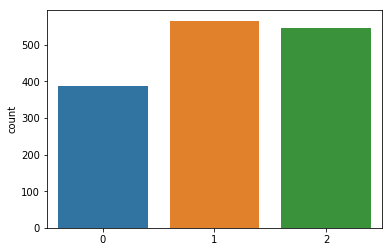

In [49]:
class_type = 3
def continous_2_cat(data):
    if data == -1:
        return -1
    if class_type ==3:
        if data <= 0.4:
            return 0
        elif data < 0.7:
            return 1
        else:
            return 2
    elif class_type == 4:
        if data <= 0.3:
            return 0
        elif data <= 0.5:
            return 1
        elif data <= 0.7:
            return 2
        else:
            return 3

targets_train_cat = list(map(continous_2_cat,targets_train ))
targets_test_cat = list(map(continous_2_cat,targets_test ))
sns.countplot(targets_train_cat)

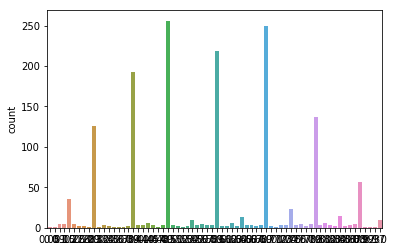

In [69]:
def continous_2_cat(data):
    if data == -1:
        return data
    return math.ceil(data*10) -1

targets_train_cat = list(map(continous_2_cat,targets_train ))
targets_test_cat = list(map(continous_2_cat,targets_test ))
sns.countplot(targets_train)

In [50]:
answers = pd.read_csv(folder+"answers.txt", header=None, delimiter=" ").as_matrix()
answers = answers[:,:-1]
answers[answers == 1.1] = 1.
answers[answers == -0.1] = 0.
print("AMT answers matrix shape: %s" % str(answers.shape))
N_ANNOT = answers.shape[1]
print("Num. annotators: %d" % N_ANNOT)

y_obs = np.empty_like(answers)
for i in range(answers.shape[0]):
    y_obs[i] = list(map(continous_2_cat, answers[i]))
y_obs = y_obs.astype('int16')
N,T = y_obs.shape
K = np.max(y_obs)+1 # asumiendo que estan ordenadas
y_obs

AMT answers matrix shape: (1498, 135)
Num. annotators: 135


array([[ 0,  2, -1, ..., -1, -1, -1],
       [ 0, -1, -1, ..., -1, -1, -1],
       [ 0, -1, -1, ..., -1, -1, -1],
       ...,
       [ 2,  2, -1, ..., -1, -1, -1],
       [ 2,  2, -1, ..., -1, -1, -1],
       [ 2,  2, -1, ..., -1, -1, -1]], dtype=int16)

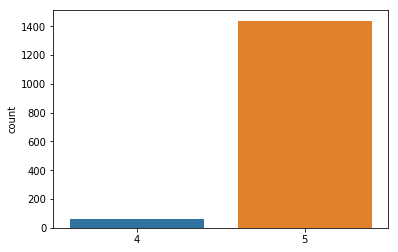

Minimum annotations in a example:  4
Maximum annotations in a example:  5
T data (expected value):  4.959946595460615
Graphics of T weights


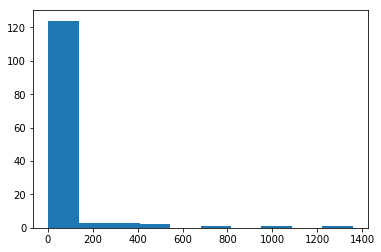

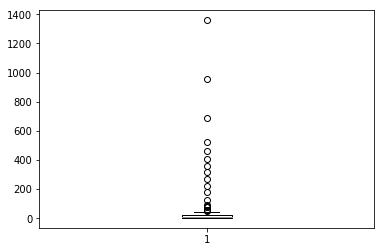

Minimum annotations by an annotator:  2
Maximum annotations by an annotator:  1359
Mean annotations by an annotator:  55.03703703703704


In [51]:
#graphics and distribution? what is T_data
T_weights = np.sum(y_obs != -1,axis=0) #distribucion de anotaciones

N_ann = np.sum(y_obs != -1,axis=1) #distribucion de anotaciones con este valor

sns.countplot(N_ann)
plt.show()
print("Minimum annotations in a example: ",N_ann.min())
print("Maximum annotations in a example: ",N_ann.max())
print("T data (expected value): ",N_ann.mean())

print("Graphics of T weights")
plt.hist(T_weights)
plt.show()

plt.boxplot(T_weights)
plt.show()
print("Minimum annotations by an annotator: ",T_weights.min())
print("Maximum annotations by an annotator: ",T_weights.max())
print("Mean annotations by an annotator: ",T_weights.mean())

shape: (1498, 135, 3)
Bayesian gaussian mixture say is 8 clusters 
DBSCAN say is 2 clusters
Affinity Propagation say is 1 clusters


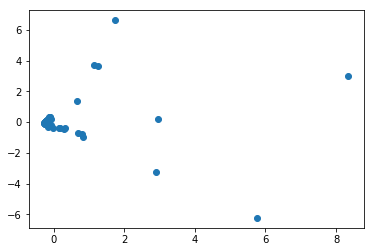

Representation for MV in 0.080277 sec
Estimation MV in 0.000474 sec
ACC MV on train: 0.7423230974632844
Normalized entropy (0-1) of repeats annotations: 0.5049686023522149


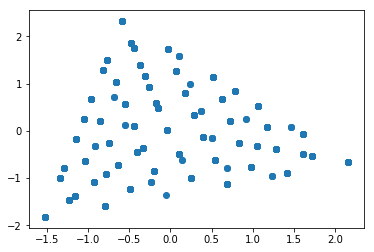

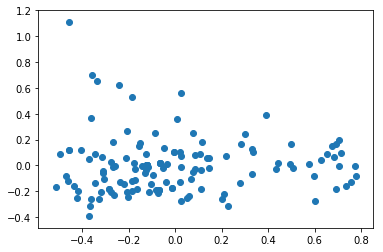

In [52]:
y_obs_categorical = set_representation(y_obs,'onehot') #for raykar
print("shape:",y_obs_categorical.shape)
annotators_pca = project_and_cluster(y_obs_categorical,DTYPE_OP=DTYPE_OP,mode_project='pca')[0]
std = StandardScaler(with_mean=True,with_std=True)
annotators_pca2 = std.fit_transform(annotators_pca)
plt.scatter(annotators_pca2[:,0],annotators_pca2[:,1])
plt.show()

label_I = LabelInference(y_obs,1,type_inf = 'mv')
mv_onehot, conf_ma = label_I.mv_labels('classes')
print("ACC MV on train:",np.mean(mv_onehot==targets_train_cat))

mv_soft = majority_voting(label_I.y_obs_repeat,repeats=True,probas=True) 
aux = []
for example in mv_soft:
    aux.append(entropy(example)/np.log(K))
print("Normalized entropy (0-1) of repeats annotations:",np.mean(aux))


predicted = np.clip(mv_soft, keras.backend.epsilon(), 1.)
data_to_cluster = []
for i in range(mv_soft.shape[0]):
    for j in range(mv_soft.shape[1]):
        ob = np.tile(keras.backend.epsilon(), mv_soft.shape[1])
        ob[j] = 1
        true = np.clip(predicted[i],keras.backend.epsilon(),1.)      
        f_l = distance_function(true, ob)  #funcion de distancia o similaridad
        data_to_cluster.append(f_l)  
data_to_cluster = np.asarray(data_to_cluster)
model = PCA(n_components=min(3,mv_soft.shape[0]) ) 
data_to_cluster = model.fit_transform(data_to_cluster)

std = StandardScaler(with_mean=True,with_std=True)
data_to_plot = std.fit_transform(data_to_cluster)
plt.scatter(data_to_plot[:,0],data_to_plot[:,1])
plt.show()


Y_ann_train, T_idx = set_representation(y_obs,"onehotvar")
from code.MixtureofGroups import *
conf_mat, conf_mat_norm  = build_conf_Yvar(Y_ann_train, T_idx, mv_soft.argmax(axis=-1))

A_rep = conf_mat_norm.reshape(conf_mat_norm.shape[0], K**2) #flatten

from sklearn.decomposition import PCA
model = PCA(2)
aux_pca = model.fit_transform(A_rep)
plt.scatter(aux_pca[:,0],aux_pca[:,1])
plt.show()


### FG-NET
---
http://biometrics.cse.msu.edu/pub/databases.html  <anotations  
http://yanweifu.github.io/FG_NET_data/index.html < images  
> Demographic Estimation from Face Images: Human vs. Machine Performance

In [3]:
folder ="../FG-Net_Age/"

columns = ["GT","file name","a1","a2","a3","a4","a5","a6","a7","a8","a9","a10"]
df_ann = pd.read_csv(folder+"fgnet_age_estimations.csv",header=None,names=columns)
df_ann.head()

,GT,file name,a1,a2,a3,a4,a5,a6,a7,a8,a9,a10
0,18,FG_890022_M_18.jpg,16.0,19.0,45.0,23.0,24.0,21.0,22.0,30.0,26.0,23.0
1,9,FG_890065_F_09.jpg,8.0,10.0,12.0,7.0,11.0,10.0,7.0,9.0,10.0,11.0
2,25,FG_890034_F_25.jpg,30.0,21.0,35.0,33.0,18.0,26.0,30.0,22.0,32.0,44.0
3,11,FG_890066_M_11.jpg,13.0,14.0,11.0,14.0,12.0,12.0,12.0,13.0,15.0,10.0
4,30,FG_890034_F_30.jpg,44.0,32.0,35.0,45.0,36.0,53.0,45.0,33.0,25.0,35.0


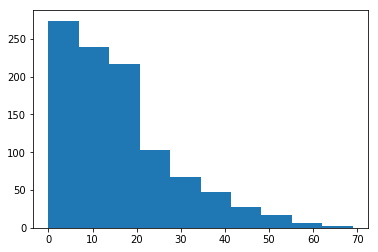

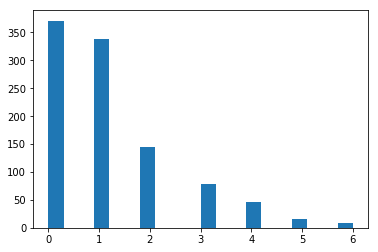

10


In [25]:
gt_aux = df_ann["GT"].values
plt.hist(gt_aux)
plt.show()

#discretizar cada 10?-- exponencial mejor...
K = int(round(aux.max()/10., 0))

Z_data = np.zeros((df_ann.shape[0]))
for i in range(Z_data.shape[0]):
    Z_data[i] = int(gt_aux[i]/10)

    
aux = df_ann.iloc[:,2:].values

r_obs = np.zeros((df_ann.shape[0],K))
for i,anns in enumerate(aux):
    for value in anns:
        r_obs[ i,int(value/10)] +=1

plt.hist(Z_data,bins=20)
plt.show()
print(K)

In [26]:
r_obs

array([[0., 2., 6., ..., 0., 0., 0.],
       [4., 6., 0., ..., 0., 0., 0.],
       [0., 1., 3., ..., 0., 0., 0.],
       ...,
       [0., 5., 5., ..., 0., 0., 0.],
       [0., 1., 3., ..., 0., 0., 0.],
       [0., 2., 6., ..., 0., 0., 0.]])

Normalized entropy (0-1) of repeats annotations: 0.2885518767426358
ACC MV on train: 0.6676646706586826


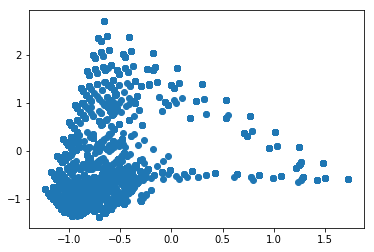

In [31]:
mv_soft = majority_voting(r_obs,repeats=True,probas=True) 
aux = []
for example in mv_soft:
    aux.append(entropy(example)/np.log(K))
print("Normalized entropy (0-1) of repeats annotations:",np.mean(aux))

print("ACC MV on train:",np.mean(mv_soft.argmax(axis=-1)==Z_data))

predicted = np.clip(mv_soft, keras.backend.epsilon(), 1.)
data_to_cluster = []
for i in range(mv_soft.shape[0]):
    for j in range(mv_soft.shape[1]):
        ob = np.tile(keras.backend.epsilon(), mv_soft.shape[1])
        ob[j] = 1
        true = np.clip(predicted[i],keras.backend.epsilon(),1.)      
        f_l = distance_function(true, ob)  #funcion de distancia o similaridad
        data_to_cluster.append(f_l)  
data_to_cluster = np.asarray(data_to_cluster)
model = PCA(n_components=min(3,mv_soft.shape[0]) ) 
data_to_cluster = model.fit_transform(data_to_cluster)

std = StandardScaler(with_mean=True,with_std=True)
data_to_plot = std.fit_transform(data_to_cluster)
plt.scatter(data_to_plot[:,0],data_to_plot[:,1])
plt.show()

### DAISEE

In [7]:
folder ="../DAiSEE/Labels/"

df_global = pd.read_csv(folder+"AllLabels.csv")
label_names = df_global.columns[1:]
df_global.head()

,ClipID,Boredom,Engagement,Confusion,Frustration
0,1100011002.avi,0,2,0,0
1,1100011003.avi,0,2,0,0
2,1100011004.avi,0,3,0,0
3,1100011005.avi,0,3,0,0
4,1100011006.avi,0,3,0,0


In [8]:
r_obs = df_global.iloc[:,1:].values
r_obs

array([[0, 2, 0, 0],
       [0, 2, 0, 0],
       [0, 3, 0, 0],
       ...,
       [1, 3, 0, 2],
       [1, 3, 1, 1],
       [0, 1, 0, 0]])

In [10]:
r_obs.sum(axis=-1).mean()

3.967619047619048

### Sentiment Analysis
---
https://eden.dei.uc.pt/~fmpr/malr/  
> Learning from multiple annotators: Distinguishing good from random labelers

http://web.eecs.umich.edu/~mozafari/datasets/crowdsourcing/
> Scaling up crowd-sourcing to very large datasets: a case for active learning  
> Active Learning for Crowd-Sourced Databases


Rodrigues utiliza: In the case of the sentimentpolarity dataset, the stopwords were removed and the remainingwords were reduced to their root by applying a stemmer. This re-sulted in a vocabulary with size 8919, which still makes a bag-of-words representation computationally expensive.  además de hacer LSA

In [2]:
#movie review website RottenTomatoes
folder = "../MTurk_paper/"

df = pd.read_csv(folder+"sentiment_polarity/mturk_answers.csv") 
print("Dataset de Sentiment Analysis shape: ",df.shape)
df.head()

FileNotFoundError: File b'../MTurk_paper/sentiment_polarity/mturk_answers.csv' does not exist

In [10]:
data_id = {}
worker_id = {}
contador_data, contador_work = 0,0

for row in df.values:
    work_id = row[0]
    inp_id = row[1]
    if inp_id not in data_id:
        data_id[inp_id] = contador_data
        contador_data+=1        
    if work_id not in worker_id:
        worker_id[work_id] = contador_work
        contador_work+=1
        
Z_train = np.zeros(contador_data, dtype='int16')
y_obs = np.ones((contador_data,contador_work),dtype='int16')*-1
texts_train_raw = [[] for _ in range(contador_data)]
texts_train_stem = [[] for _ in range(contador_data)]
for row in df.values:
    work_id = row[0]
    inp_id = row[1]
    text = row[2]
    gt = row[4]
    ann = row[5]
    
    Z_train[data_id[inp_id]] = (gt == "pos")*1
    y_obs[data_id[inp_id], worker_id[work_id]] = (ann == "pos")*1
    texts_train_raw[data_id[inp_id]] = text
    texts_train_stem[data_id[inp_id]] = row[3]
    
    
N, T = y_obs.shape
K = 2

np.savetxt("./Sentiment/rotten/answers.txt", y_obs,delimiter=' ', fmt='%d')
np.savetxt("./Sentiment/rotten/sent_train.txt", Z_train,delimiter=' ', fmt='%d')
with open("./Sentiment/rotten/texts_train.txt", 'w') as fp:
    fp.write("\n".join(texts_train_raw))
with open("./Sentiment/rotten/texts_train_stem.txt", 'w') as fp:
    fp.write("\n".join(texts_train_stem))
y_obs.shape

(4999, 203)

In [2]:
folder = "./Sentiment/rotten/" #from kaggle.. GT data labeled
df = pd.read_csv(folder+"train.tsv", sep='\t')

#hard data
mask_neg = (df["Sentiment"] == 1).values
mask_pos = (df["Sentiment"] == 3).values 
text_neg = df[mask_neg]["Phrase"].values
text_pos = df[mask_pos]["Phrase"].values

sent_test = np.concatenate([np.zeros(text_neg.shape[0]), np.ones(text_pos.shape[0])])
texts_test = np.asarray(list(text_neg)+list(text_pos))

from sklearn.utils import shuffle
texts_test, sent_test = shuffle(texts_test, sent_test)

#np.savetxt(folder+"/sent_test.txt", sent_test[:6000],delimiter=' ', fmt='%d')
#with open(folder+"/texts_test.txt", 'w') as fp:
#    fp.write("\n".join(texts_test[:6000]))   

In [8]:
from keras import preprocessing
MAX_NB_WORDS = 14000
tokenizer = preprocessing.text.Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts_test)
sequences_test = tokenizer.texts_to_sequences(texts_test)
max_L = 50 
X_test = preprocessing.sequence.pad_sequences(sequences_test, maxlen=max_L,dtype='int32', value=0,padding='pre')
EMBEDDING_DIM = 300
GLOVE_FILE = "../GLOVE/glove.6B.%dd.txt"%(EMBEDDING_DIM)
embeddings_index = {}
with open(GLOVE_FILE) as file:
    for line in file:
        values = line.split()
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[values[0]] = coefs
print('Preparing embedding matrix.')
sorted_x = sorted(tokenizer.word_counts.items(), key=lambda kv: kv[1], reverse=True)
vocab = {value[0]:tokenizer.word_index[value[0]] for i, value in enumerate(sorted_x) if i < MAX_NB_WORDS}
embedding_matrix = np.zeros((len(vocab)+1, EMBEDDING_DIM))
v=0
for word, i in vocab.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector # words not found in embedding index will be all-zeros.
        v+=1
del embeddings_index, sorted_x, tokenizer
gc.collect()
print("Words found on glove: ",v)

Preparing embedding matrix.
Words found on glove:  13725


In [23]:
import keras
model_mvsoft = keras.models.load_model("aux.h5")

### predict x
Z_pred = model_mvsoft.predict_classes(X_test, batch_size=1024)

mask_mistakes = (sent_test != Z_pred)
np.sum(mask_mistakes) #si guardo solo los errores va a tener muy mal acc afuera no??

28591

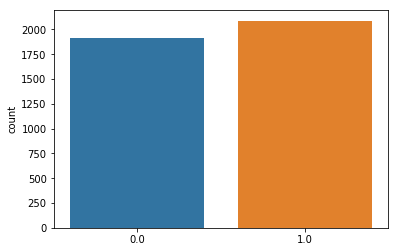

In [24]:
final_mask = mask_mistakes & (np.cumsum(mask_mistakes)<4000)
sns.countplot(sent_test[final_mask])

In [25]:
np.savetxt(folder+"/sent_test.txt", sent_test[final_mask],delimiter=' ', fmt='%d')
with open(folder+"/texts_test.txt", 'w') as fp:
    fp.write("\n".join(texts_test[final_mask]))   

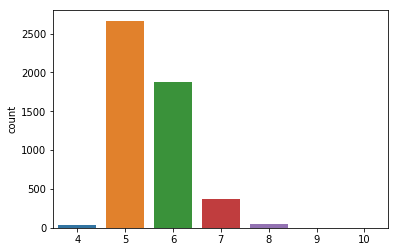

Minimum annotations in a example:  4
Maximum annotations in a example:  10
T data (expected value):  5.550310062012403
Graphics of T weights


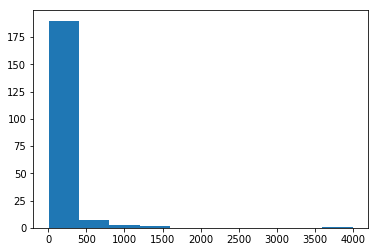

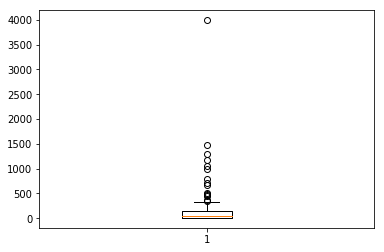

Minimum annotations by an annotator:  5
Maximum annotations by an annotator:  3993
Mean annotations by an annotator:  136.67980295566502


In [26]:
#graphics and distribution? what is T_data
T_weights = np.sum(y_obs != -1,axis=0) #distribucion de anotaciones
N_ann = np.sum(y_obs != -1,axis=1) #distribucion de anotaciones con este valor

sns.countplot(N_ann)
plt.show()
print("Minimum annotations in a example: ",N_ann.min())
print("Maximum annotations in a example: ",N_ann.max())
print("T data (expected value): ",N_ann.mean())

print("Graphics of T weights")
plt.hist(T_weights)
plt.show()

plt.boxplot(T_weights)
plt.show()
print("Minimum annotations by an annotator: ",T_weights.min())
print("Maximum annotations by an annotator: ",T_weights.max())
print("Mean annotations by an annotator: ",T_weights.mean())

Representation for MV in 0.212330 sec
Estimation MV in 0.000391 sec
ACC MV on train: 0.8895779155831166
F1 MV on train: 0.8895779155831166
Normalized entropy (0-1) of repeats annotations: 0.49546839861751707


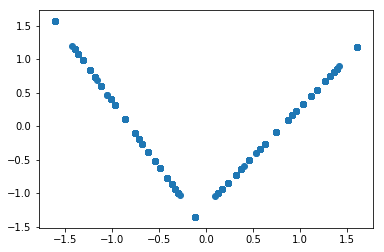

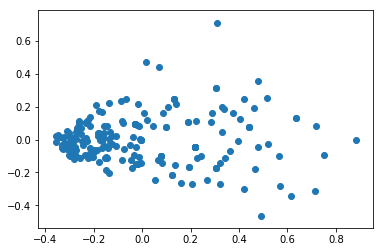

In [45]:
from sklearn.metrics import f1_score
label_I = LabelInference(y_obs,1,type_inf = 'mv')
mv_onehot, conf = label_I.mv_labels('classes')
print("ACC MV on train:",np.mean(mv_onehot==Z_data))
print("F1 MV on train:",f1_score(Z_data,mv_onehot,average="micro"))


mv_soft = majority_voting(label_I.y_obs_repeat,repeats=True,probas=True) 
aux = []
for example in mv_soft:
    aux.append(entropy(example)/np.log(K))
print("Normalized entropy (0-1) of repeats annotations:",np.mean(aux))

predicted = np.clip(mv_soft, keras.backend.epsilon(), 1.)
data_to_cluster = []
for i in range(mv_soft.shape[0]):
    for j in range(mv_soft.shape[1]):
        ob = np.tile(keras.backend.epsilon(), mv_soft.shape[1])
        ob[j] = 1
        true = np.clip(predicted[i],keras.backend.epsilon(),1.)      
        f_l = distance_function(true, ob)  #funcion de distancia o similaridad
        data_to_cluster.append(f_l)  
data_to_cluster = np.asarray(data_to_cluster)
model = PCA(n_components=min(3,mv_soft.shape[1]) ) 
data_to_cluster = model.fit_transform(data_to_cluster)

std = StandardScaler(with_mean=True,with_std=True)
data_to_plot = std.fit_transform(data_to_cluster)
plt.scatter(data_to_plot[:,0],data_to_plot[:,1])
plt.show()


Y_ann_train, T_idx = set_representation(y_obs,"onehotvar")
from code.MixtureofGroups import *
conf_mat, conf_mat_norm  = build_conf_Yvar(Y_ann_train, T_idx, mv_soft.argmax(axis=-1))

A_rep = conf_mat_norm.reshape(conf_mat_norm.shape[0], K**2) #flatten

from sklearn.decomposition import PCA
model = PCA(2)
aux_pca = model.fit_transform(A_rep)
plt.scatter(aux_pca[:,0],aux_pca[:,1])
plt.show()

In [97]:
folder = "../Mozafari/Sentiment/"

columns = ["PrimaryKey"]
for i in range(1,6):
    columns.append("User"+str(i))
    columns.append("realLabel")
    columns.append("actual_tweat")
df_ann = pd.read_csv(folder+"tweets10k.crd",header=None,names=columns)
print(df_ann.shape)
df_ann.head()

(1000, 16)


/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/pandas/io/parsers.py:709: UserWarning: Duplicate names specified. This will raise an error in the future.
  return _read(filepath_or_buffer, kwds)


,PrimaryKey,User1,realLabel,actual_tweat,User2,realLabel.1,actual_tweat.1,User3,realLabel.2,actual_tweat.2,User4,realLabel.3,actual_tweat.3,User5,realLabel.4,actual_tweat.4
0,1,A17G2QHR8AH5VV,1,0,A3QTDW5WP4GFKV,1,0,A2QNS7MODF0A2N,1,0,A3TSHG5R492EHU,1,0,A2NBP5OTOYX3WK,1,0
1,2,A3OZ8KF0HWSVWK,1,1,A3TSHG5R492EHU,1,1,A1SCNO7L71ITFY,1,1,A2SB5KUOAGU70U,1,1,A1YW00TFC187CC,1,0
2,3,A2460QZM5TZC4V,1,1,A52AHJEUWFSA2,1,1,A2N2KQXUPLNDWI,1,1,A3OZ8KF0HWSVWK,1,1,A3U1K9X1LXA5JA,1,1
3,4,AADB14P6ZCSOC,0,0,A1SCNO7L71ITFY,0,0,A29PMRCRJ7Q9ZD,0,0,A2QNS7MODF0A2N,0,0,A3TSHG5R492EHU,0,0
4,5,A2460QZM5TZC4V,1,0,A3P08N6X9HDJ2V,1,0,A3OZ8KF0HWSVWK,1,0,A2H3M1JVY991Q3,1,1,ARX0S1CIDJLOX,1,0


In [48]:
df_gt = pd.read_csv(folder+"tweets10k.details",header=None,names=["PrimaryKey","realLabel", "actual_tweat"],index_col=False)
print(df_gt.shape)
df_gt.head() ### could be test..

(10000, 3)


,PrimaryKey,realLabel,actual_tweat
0,1,1,@chazdrums if i know how to do something
1,2,1,@m_ariii alright
2,3,1,@lsndr87 Good Luck Girl
3,4,0,@sloanb Got it
4,5,1,@lilyroseallen that's hotel tv's for ya


In [ ]:
df_gt["realLabel"].unique()

In [104]:
data_id = {}
worker_id = {}
contador_data, contador_work = 0,0

for row in df_ann.values:
    inp_id = row[0]
    if inp_id not in data_id:
        data_id[inp_id] = contador_data
        contador_data+=1        
    
    for i in np.arange(1,len(row),3):
        work_id = row[i]
        if work_id not in worker_id:
            worker_id[work_id] = contador_work
            contador_work+=1  

Z_data = np.zeros(contador_data, dtype='int16')
y_obs = np.ones((contador_data,contador_work),dtype='int16')*-1
for row in df_ann.values:
    inp_id = row[0]
    #text = row[2] #extraer desde df_gt
    gt = row[2]
    Z_data[data_id[inp_id]] = (gt == 1)*1
    
    for i in np.arange(1,len(row),3):
        work_id = row[i]
        ann = row[i+2]
        y_obs[data_id[inp_id], worker_id[work_id]] = (ann == 1)*1
    
N, T = y_obs.shape
K = 2
#Z_data
y_obs.shape

(1000, 83)

In [ ]:
####### GUARDAR DATA
data_id = {}
worker_id = {}
contador_data, contador_work = 0,0

for row in df_ann.values:
    inp_id = row[0]
    if inp_id not in data_id:
        data_id[inp_id] = contador_data
        contador_data+=1        
    
    for i in np.arange(1,len(row),3):
        work_id = row[i]
        if work_id not in worker_id:
            worker_id[work_id] = contador_work
            contador_work+=1  
            
Z_train = np.zeros(contador_data, dtype='int16')
Z_test = []
texts_train = [ [] for _ in range(contador_data)]
texts_test = []
for row in df_gt.values:
    if row[0] in data_id:
        Z_train[data_id[row[0]]] = (row[1]==1)*1
        texts_train[data_id[row[0]]] = row[2]
    else:
        Z_test.append((row[1]==1)*1)
        texts_test.append(row[2])
        
y_obs = np.ones((contador_data,contador_work),dtype='int16')*-1
for row in df_ann.values:
    for i in np.arange(1,len(row),3):
        work_id = row[i]
        ann = row[i+2]
        y_obs[data_id[row[0]], worker_id[work_id]] = (ann == 1)*1
        
np.savetxt("./Sentiment/answers.txt", y_obs,delimiter=' ', fmt='%d')
np.savetxt("./Sentiment/sent_train.txt", Z_train,delimiter=' ', fmt='%d')
np.savetxt("./Sentiment/sent_test.txt", Z_test,delimiter=' ', fmt='%d')
with open("./Sentiment/texts_train.txt", 'w') as fp:
    fp.write("\n".join(texts_train))
with open("./Sentiment/texts_test.txt", 'w') as fp:
    fp.write("\n".join(texts_test))   

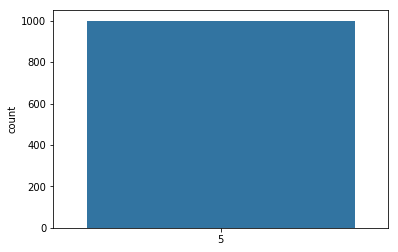

Minimum annotations in a example:  5
Maximum annotations in a example:  5
T data (expected value):  5.0
Graphics of T weights


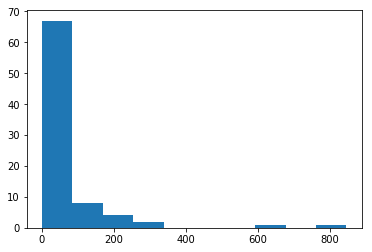

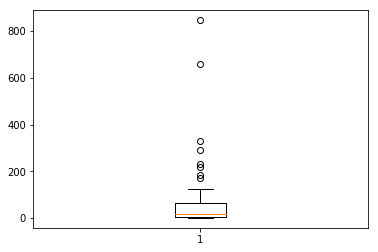

Minimum annotations by an annotator:  1
Maximum annotations by an annotator:  846
Mean annotations by an annotator:  60.24096385542169


In [99]:
#graphics and distribution? what is T_data
T_weights = np.sum(y_obs != -1,axis=0) #distribucion de anotaciones
N_ann = np.sum(y_obs != -1,axis=1) #distribucion de anotaciones con este valor

sns.countplot(N_ann)
plt.show()
print("Minimum annotations in a example: ",N_ann.min())
print("Maximum annotations in a example: ",N_ann.max())
print("T data (expected value): ",N_ann.mean())

print("Graphics of T weights")
plt.hist(T_weights)
plt.show()

plt.boxplot(T_weights)
plt.show()
print("Minimum annotations by an annotator: ",T_weights.min())
print("Maximum annotations by an annotator: ",T_weights.max())
print("Mean annotations by an annotator: ",T_weights.mean())

Representation for MV in 0.044220 sec
Estimation MV in 0.000409 sec
ACC MV on train: 0.696
F1 MV on train: 0.696
Normalized entropy (0-1) of repeats annotations: 0.4119131022397207


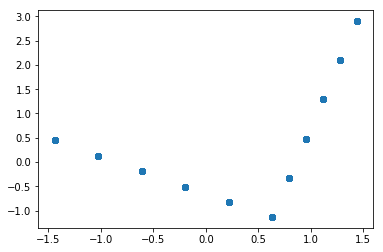

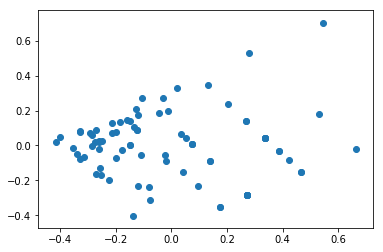

In [100]:
from sklearn.metrics import f1_score
label_I = LabelInference(y_obs,1,type_inf = 'mv')
mv_onehot, conf = label_I.mv_labels('classes')
print("ACC MV on train:",np.mean(mv_onehot==Z_data))
print("F1 MV on train:",f1_score(Z_data,mv_onehot,average="micro"))


mv_soft = majority_voting(label_I.y_obs_repeat,repeats=True,probas=True) 
aux = []
for example in mv_soft:
    aux.append(entropy(example)/np.log(K))
print("Normalized entropy (0-1) of repeats annotations:",np.mean(aux))

predicted = np.clip(mv_soft, keras.backend.epsilon(), 1.)
data_to_cluster = []
for i in range(mv_soft.shape[0]):
    for j in range(mv_soft.shape[1]):
        ob = np.tile(keras.backend.epsilon(), mv_soft.shape[1])
        ob[j] = 1
        true = np.clip(predicted[i],keras.backend.epsilon(),1.)      
        f_l = distance_function(true, ob)  #funcion de distancia o similaridad
        data_to_cluster.append(f_l)  
data_to_cluster = np.asarray(data_to_cluster)
model = PCA(n_components=min(3,mv_soft.shape[1]) ) 
data_to_cluster = model.fit_transform(data_to_cluster)

std = StandardScaler(with_mean=True,with_std=True)
data_to_plot = std.fit_transform(data_to_cluster)
plt.scatter(data_to_plot[:,0],data_to_plot[:,1])
plt.show()


Y_ann_train, T_idx = set_representation(y_obs,"onehotvar")
from code.MixtureofGroups import *
conf_mat, conf_mat_norm  = build_conf_Yvar(Y_ann_train, T_idx, mv_soft.argmax(axis=-1))

A_rep = conf_mat_norm.reshape(conf_mat_norm.shape[0], K**2) #flatten

from sklearn.decomposition import PCA
model = PCA(2)
aux_pca = model.fit_transform(A_rep)
plt.scatter(aux_pca[:,0],aux_pca[:,1])
plt.show()

In [ ]:
folder = "../Probar/Sentiment/data/"
from scipy.io import loadmat
file1 = loadmat(folder+"8-5.mat")
file2 = loadmat(folder+"patterns8.mat")
file3 = loadmat(folder+"indices.mat")

file1

In [92]:
"""
This archive contains collection of 16327 articles from three Irish online news sources 
(RTE,The Irish Times,The Irish Independent) collected between 2009-07-08 and 2009-10-16. 
A subset of 1660 of these articles were annotated manually by 33 users during that period.
"""

folder = "../Probar/otroSentiment/"
#df_ann = pd.read_csv(folder+"/sentiment_main_annotations.csv")
df_ann = pd.read_csv(folder+"/sentiment_all_annotations.csv",names=["article_id","user_id","annotation"])

#texts in TF representation..
articles_header = ["article_id","article_data(yyyy-mm-dd)","provider(rte,irishtimes,independent)"] +["term_index"+str(i)+":freq" for i in np.arange(1175)]
df_articles = pd.read_csv(folder+"/sentiment_all_articles.csv",header=None,engine='python',names=articles_header)
print("Data (X): ",df_articles.shape)

#vocabulary
df_terms = pd.read_csv(folder+"/sentiment_all_terms.csv",names=["term_id","term_text"], encoding = "ISO-8859-1")
print("Vocabulary shape:",df_terms.shape)

print(df_ann.shape)
df_ann.head()

Data (X):  (16327, 1178)
Vocabulary shape: (79308, 2)
(9603, 3)


,article_id,user_id,annotation
0,17,6,negative
1,17,7,negative
2,17,3,negative
3,17,5,negative
4,17,4,negative


In [91]:
df_annotations["annotation"].unique()

array(['negative', 'positive', 'irrelevant'], dtype=object)

In [93]:
#.. no hay GT..

data_id = {}
worker_id = {}
contador_data, contador_work = 0,0
for row in df_ann.values:
    inp_id = row[0]
    work_id = row[1]
    if inp_id not in data_id:
        data_id[inp_id] = contador_data
        contador_data+=1        
    if work_id not in worker_id:
        worker_id[work_id] = contador_work
        contador_work+=1  

y_obs = np.ones((contador_data,contador_work),dtype='int16')*-1
for row in df_ann.values:
    inp_id = row[0]
    #text = row[2] #extraer ]TF desde df_articles

    work_id = row[1]
    ann = row[2]
    y_obs[data_id[inp_id], worker_id[work_id]] = (ann == "positive")*1

N, T = y_obs.shape
K = 2
#Z_data
y_obs.shape

(1660, 33)

In [94]:
y_obs

array([[ 0,  0,  0, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [ 0,  0,  0, ..., -1, -1, -1],
       ...,
       [-1, -1,  0, ..., -1, -1, -1],
       [-1,  0,  0, ...,  1, -1, -1],
       [-1,  1,  1, ...,  1, -1, -1]], dtype=int16)

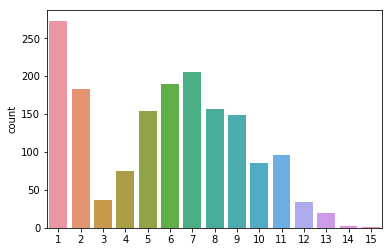

Minimum annotations in a example:  1
Maximum annotations in a example:  15
T data (expected value):  5.784939759036145
Graphics of T weights


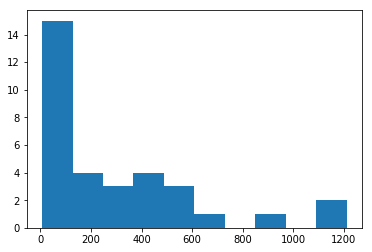

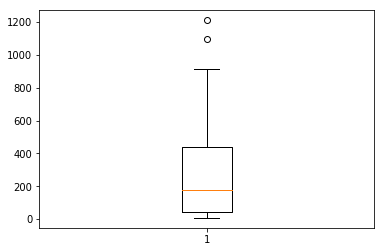

Minimum annotations by an annotator:  7
Maximum annotations by an annotator:  1211
Mean annotations by an annotator:  291.0


In [95]:
#graphics and distribution? what is T_data
T_weights = np.sum(y_obs != -1,axis=0) #distribucion de anotaciones
N_ann = np.sum(y_obs != -1,axis=1) #distribucion de anotaciones con este valor

sns.countplot(N_ann)
plt.show()
print("Minimum annotations in a example: ",N_ann.min())
print("Maximum annotations in a example: ",N_ann.max())
print("T data (expected value): ",N_ann.mean())

print("Graphics of T weights")
plt.hist(T_weights)
plt.show()

plt.boxplot(T_weights)
plt.show()
print("Minimum annotations by an annotator: ",T_weights.min())
print("Maximum annotations by an annotator: ",T_weights.max())
print("Mean annotations by an annotator: ",T_weights.mean())

Representation for MV in 0.098708 sec
Estimation MV in 0.000733 sec
Normalized entropy (0-1) of repeats annotations: 0.3135694930931521


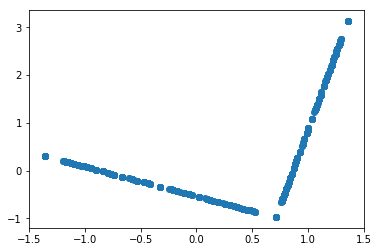

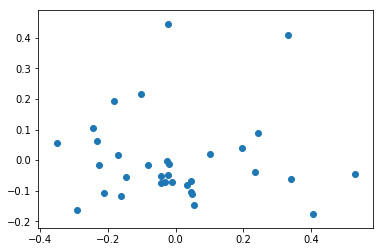

In [96]:
from sklearn.metrics import f1_score
label_I = LabelInference(y_obs,1,type_inf = 'mv')
mv_onehot, conf = label_I.mv_labels('classes')

mv_soft = majority_voting(label_I.y_obs_repeat,repeats=True,probas=True) 
aux = []
for example in mv_soft:
    aux.append(entropy(example)/np.log(K))
print("Normalized entropy (0-1) of repeats annotations:",np.mean(aux))

predicted = np.clip(mv_soft, keras.backend.epsilon(), 1.)
data_to_cluster = []
for i in range(mv_soft.shape[0]):
    for j in range(mv_soft.shape[1]):
        ob = np.tile(keras.backend.epsilon(), mv_soft.shape[1])
        ob[j] = 1
        true = np.clip(predicted[i],keras.backend.epsilon(),1.)      
        f_l = distance_function(true, ob)  #funcion de distancia o similaridad
        data_to_cluster.append(f_l)  
data_to_cluster = np.asarray(data_to_cluster)
model = PCA(n_components=min(3,mv_soft.shape[1]) ) 
data_to_cluster = model.fit_transform(data_to_cluster)

std = StandardScaler(with_mean=True,with_std=True)
data_to_plot = std.fit_transform(data_to_cluster)
plt.scatter(data_to_plot[:,0],data_to_plot[:,1])
plt.show()


Y_ann_train, T_idx = set_representation(y_obs,"onehotvar")
from code.MixtureofGroups import *
conf_mat, conf_mat_norm  = build_conf_Yvar(Y_ann_train, T_idx, mv_soft.argmax(axis=-1))

A_rep = conf_mat_norm.reshape(conf_mat_norm.shape[0], K**2) #flatten

from sklearn.decomposition import PCA
model = PCA(2)
aux_pca = model.fit_transform(A_rep)
plt.scatter(aux_pca[:,0],aux_pca[:,1])
plt.show()

### Crowdscale
https://sites.google.com/site/crowdscale2013/shared-task


* Job Title: Judge emotions about weather from Twitter
    * 0 Negative
    * 1 Neutral / author is just sharing information
    * 2 Positive
    * 3 Tweet not related to weather condition
    * 4 I can't tell



In [65]:
folder = "../CrowsourcingatScale/"
df_ann = pd.read_csv(folder+"cf-sentiment-basic.csv")
df_gt = pd.read_csv(folder+"cf-gold/reference_100%.csv")
df_ann.head()

,question,rater,judgment
0,81988805,df4efb63-1273-49f9-8ad1-bbe823db7e1c,3
1,81988805,297b9a2d-ba91-4611-b0ad-bf96d4e9e76d,3
2,81988805,b162cdcb-4d3e-48da-ba9e-f29a0ac8dd6e,3
3,81988805,e99c283f-ede0-40c4-9914-87a2a11e6f2c,3
4,81988805,42a4a1c9-4e4c-44ac-a20a-d9870532867d,3


In [87]:
aux_df = pd.read_csv(folder+"kaggle/train.csv")
print(aux_df.shape)
aux_df.head()

(77946, 28)


,id,tweet,state,location,s1,s2,s3,s4,s5,w1,...,k6,k7,k8,k9,k10,k11,k12,k13,k14,k15
0,1,Jazz for a Rainy Afternoon: {link},oklahoma,Oklahoma,0.0,0.0,1.0,0.000,0.000,0.800,...,0.0,0.000,0.0,0.000,1.0,0.0,0.0,0.000,0.0,0.0
1,2,RT: @mention: I love rainy days.,florida,Miami-Ft. Lauderdale,0.0,0.0,0.0,1.000,0.000,0.196,...,0.0,0.000,0.0,0.000,1.0,0.0,0.0,0.000,0.0,0.0
2,3,Good Morning Chicago! Time to kick the Windy C...,idaho,NaN,0.0,0.0,0.0,0.000,1.000,0.000,...,0.0,1.000,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.0
3,6,Preach lol! :) RT @mention: #alliwantis this t...,minnesota,Minneapolis-St. Paul,0.0,0.0,0.0,1.000,0.000,1.000,...,0.0,0.604,0.0,0.196,0.0,0.0,0.0,0.201,0.0,0.0
4,9,@mention good morning sunshine,rhode island,Purgatory,0.0,0.0,0.0,0.403,0.597,1.000,...,0.0,0.000,0.0,0.000,0.0,0.0,0.0,1.000,0.0,0.0


In [66]:
#ver como descargar los tweets...
CONSUMER_KEY = "gQ1RX1eqCRS39n1dmL9nVzAEp"
CONSUMER_SECRET = "iMiZA2xXC4o7TsypLHj22HP1R0SAdfYqxYgFDKU33mra2SGhyA"
OAUTH_TOKEN = "320425023-iyx7eywe75Po9VtkaOkhcrlhXGFTwzrYYq55xcoH"
OAUTH_TOKEN_SECRET = "4GAlKtNyS0Z4SIOdo4DnlFsBl8KlfczOhGy8I4yByF1Tb"

In [98]:
tweets = api.user_timeline("84314377")
print("Tweets: ", len(tweets))
for aux in tweets:
    print(aux.text)

Tweets:  1
im working in dubai


In [92]:
import tweepy
auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
auth.set_access_token(OAUTH_TOKEN, OAUTH_TOKEN_SECRET)
api = tweepy.API(auth)

tweet = api.get_status("264183816548130816")
print(tweet.text)

Gas by my house hit $3.39!!!! I'm going to Chapel Hill on Sat. :)


In [67]:
aux = pd.read_csv(folder+"github/weather-agg-DFE.csv")
print("Cantidad de data: ",len(aux["tweet_id"].unique()))
#print("Cantidad de workers: ",len(aux["_worker_id"].unique()))
aux.head()

Cantidad de data:  1000


,_unit_id,_canary,_unit_state,_trusted_judgments,_last_judgment_at,what_emotion_does_the_author_express_specifically_about_the_weather,what_emotion_does_the_author_express_specifically_about_the_weather:confidence,gold_answer,tweet_id,tweet_text
0,314960380,NaN,finalized,20,8/24/13 0:21,Positive,0.8439,NaN,81990560,Grilling kabobs on the grill last night was am...
1,314960381,NaN,finalized,20,8/24/13 0:49,Negative,0.6963,NaN,84314377,The slowest day ever !! And the weather makes ...
2,314960382,NaN,finalized,20,8/24/13 0:55,Neutral / author is just sharing information,0.8802,NaN,82846118,Fire Weather Watch issued May 17 at 4:21PM CDT...
3,314960383,NaN,finalized,20,8/24/13 0:48,Positive,0.6897,NaN,82843785,Im going to lunch early today. The weather i...
4,314960384,NaN,finalized,20,8/24/13 1:19,Neutral / author is just sharing information,0.6153,NaN,82840144,Weekend Weather Causes Delays In I-270 Bridge ...


In [73]:
aux = pd.read_csv(folder+"old_data/weather-non-agg-DFE.csv")
print("Cantidad de data: ",len(aux["tweet_id"].unique()))
print("Cantidad de workers: ",len(aux["_worker_id"].unique()))
aux

Cantidad de data:  1000
Cantidad de workers:  102


,_unit_id,_created_at,_canary,_id,_started_at,_channel,_trust,_worker_id,_country,_region,_city,_ip,what_emotion_does_the_author_express_specifically_about_the_weather,gold_answer,tweet_id,tweet_text
0,314960380,8/23/2013 23:57:30,NaN,1038995940,8/23/2013 23:57:20,probux,1.0000,18939994,PRT,14,Vila Franca De Xira,2.83.187.82,Neutral / author is just sharing information,NaN,81990560,Grilling kabobs on the grill last night was am...
1,314960380,8/24/2013 00:09:18,NaN,1039004532,8/24/2013 00:09:05,eup_slw,0.4658,19028457,DEU,02,Holzkirchen,188.192.44.105,Negative,NaN,81990560,Grilling kabobs on the grill last night was am...
2,314960380,8/24/2013 00:09:31,NaN,1039004700,8/24/2013 00:08:14,clixsense,0.7630,14400603,SRB,NaN,NaN,178.221.70.117,Positive,NaN,81990560,Grilling kabobs on the grill last night was am...
3,314960380,8/24/2013 00:11:55,NaN,1039006547,8/24/2013 00:11:13,clixsense,0.6429,17475684,IND,02,Tirupati,117.204.49.167,Positive,NaN,81990560,Grilling kabobs on the grill last night was am...
4,314960380,8/24/2013 00:13:22,NaN,1039007700,8/24/2013 00:11:50,stuffpoint,0.9286,11800825,SWE,10,Avesta,83.253.207.185,Positive,NaN,81990560,Grilling kabobs on the grill last night was am...
5,314960380,8/24/2013 00:14:19,NaN,1039008265,8/24/2013 00:12:36,clixsense,0.7708,18381123,PHL,NaN,NaN,203.215.117.7,Positive,NaN,81990560,Grilling kabobs on the grill last night was am...
6,314960380,8/24/2013 00:14:37,NaN,1039008516,8/24/2013 00:13:41,clixsense,0.8438,10235355,GBR,X1,Llandegfan,86.142.173.53,Positive,NaN,81990560,Grilling kabobs on the grill last night was am...
7,314960380,8/24/2013 00:15:07,NaN,1039008820,8/24/2013 00:14:24,clixsense,0.7778,16526185,GBR,B3,Warfield,93.96.182.52,Positive,NaN,81990560,Grilling kabobs on the grill last night was am...
8,314960380,8/24/2013 00:15:30,NaN,1039009089,8/24/2013 00:14:42,clixsense,0.5654,14472526,IND,38,Bokaro,117.205.147.88,Negative,NaN,81990560,Grilling kabobs on the grill last night was am...
9,314960380,8/24/2013 00:16:01,NaN,1039009458,8/24/2013 00:14:32,clixsense,0.5520,8939802,PHL,NaN,NaN,203.215.116.50,Positive,NaN,81990560,Grilling kabobs on the grill last night was am...


In [41]:
bla = pd.read_csv(folder+"kaggle/test.csv")

texts_aux = aux["tweet_text"].values

for i, pepe_i in enumerate(aux.values):
    value = pepe_i[-1]
    
    f1 = aux_df[aux_df["tweet"] == value]
    f2 = bla[bla["tweet"] == value]
          
    if len(f1) != 0:
        print("Found on train: id kaggle: %s e id crowdscale %s "%(f1["id"].values, pepe_i[-2]))
        print("pos en crowdscale: %d, pos en crowdflower %d"%(data_id[pepe_i[-2]],i))
        #print(f1.head())
    if len(f2) != 0:
        print("Found on test: id kaggle: %s e id crowdscale %s "%(f1["id"].values, pepe_i[-2]))
        print("pos en crowdscale: %d, pos en crowdflower %d"%(data_id[pepe_i[-2]],i))
        #print(f2.head())
          

Found on train: id kaggle: [18907] e id crowdscale 84314377 
pos en crowdscale: 67271, pos en crowdflower 1
Found on train: id kaggle: [71807] e id crowdscale 82846118 
pos en crowdscale: 33070, pos en crowdflower 2
Found on train: id kaggle: [4124] e id crowdscale 82843785 
pos en crowdscale: 30759, pos en crowdflower 3
Found on train: id kaggle: [39282] e id crowdscale 82840144 
pos en crowdscale: 28281, pos en crowdflower 4
Found on train: id kaggle: [75685] e id crowdscale 82510997 
pos en crowdscale: 8883, pos en crowdflower 5
Found on train: id kaggle: [111184] e id crowdscale 84313352 
pos en crowdscale: 66251, pos en crowdflower 6
Found on train: id kaggle: [1973] e id crowdscale 81211801 
pos en crowdscale: 94832, pos en crowdflower 7
Found on train: id kaggle: [58643] e id crowdscale 82852809 
pos en crowdscale: 39008, pos en crowdflower 8
Found on train: id kaggle: [3449] e id crowdscale 79194811 
pos en crowdscale: 78225, pos en crowdflower 9
Found on train: id kaggle: [975

Found on train: id kaggle: [86922] e id crowdscale 82510693 
pos en crowdscale: 8580, pos en crowdflower 94
Found on train: id kaggle: [113116] e id crowdscale 82839844 
pos en crowdscale: 27981, pos en crowdflower 97
Found on train: id kaggle: [97720] e id crowdscale 82516775 
pos en crowdscale: 14114, pos en crowdflower 98
Found on train: id kaggle: [46043] e id crowdscale 82849313 
pos en crowdscale: 35528, pos en crowdflower 99
Found on train: id kaggle: [41551] e id crowdscale 79197151 
pos en crowdscale: 80555, pos en crowdflower 101
Found on train: id kaggle: [18400] e id crowdscale 81169556 
pos en crowdscale: 90168, pos en crowdflower 103
Found on train: id kaggle: [16942] e id crowdscale 84317392 
pos en crowdscale: 67925, pos en crowdflower 104
Found on train: id kaggle: [76462] e id crowdscale 82839115 
pos en crowdscale: 27252, pos en crowdflower 105
Found on train: id kaggle: [98344] e id crowdscale 84305178 
pos en crowdscale: 59520, pos en crowdflower 106
Found on train

Found on train: id kaggle: [86280] e id crowdscale 81213147 
pos en crowdscale: 96174, pos en crowdflower 194
Found on train: id kaggle: [28734] e id crowdscale 84320750 
pos en crowdscale: 71282, pos en crowdflower 195
Found on train: id kaggle: [12184] e id crowdscale 83254598 
pos en crowdscale: 39640, pos en crowdflower 196
Found on train: id kaggle: [41282] e id crowdscale 82511269 
pos en crowdscale: 9155, pos en crowdflower 197
Found on train: id kaggle: [41910] e id crowdscale 80059665 
pos en crowdscale: 89695, pos en crowdflower 198
Found on train: id kaggle: [20810] e id crowdscale 81993145 
pos en crowdscale: 3850, pos en crowdflower 199
Found on train: id kaggle: [5842] e id crowdscale 82851664 
pos en crowdscale: 37870, pos en crowdflower 200
Found on train: id kaggle: [114517] e id crowdscale 81992407 
pos en crowdscale: 3112, pos en crowdflower 201
Found on train: id kaggle: [51672] e id crowdscale 81996594 
pos en crowdscale: 6706, pos en crowdflower 203
Found on train

Found on train: id kaggle: [950] e id crowdscale 81214896 
pos en crowdscale: 97917, pos en crowdflower 295
Found on train: id kaggle: [117856] e id crowdscale 82852510 
pos en crowdscale: 38711, pos en crowdflower 298
Found on train: id kaggle: [26324] e id crowdscale 80054061 
pos en crowdscale: 85644, pos en crowdflower 300
Found on train: id kaggle: [104907] e id crowdscale 84305417 
pos en crowdscale: 59758, pos en crowdflower 301
Found on train: id kaggle: [2404] e id crowdscale 82844546 
pos en crowdscale: 31516, pos en crowdflower 302
Found on train: id kaggle: [81827] e id crowdscale 83267294 
pos en crowdscale: 44533, pos en crowdflower 304
Found on train: id kaggle: [40475] e id crowdscale 80056141 
pos en crowdscale: 86201, pos en crowdflower 305
Found on train: id kaggle: [115742] e id crowdscale 81994619 
pos en crowdscale: 4731, pos en crowdflower 306
Found on train: id kaggle: [119630] e id crowdscale 81996571 
pos en crowdscale: 6683, pos en crowdflower 307
Found on tr

Found on train: id kaggle: [95815] e id crowdscale 83255916 
pos en crowdscale: 40912, pos en crowdflower 392
Found on train: id kaggle: [110786] e id crowdscale 81992855 
pos en crowdscale: 3560, pos en crowdflower 393
Found on train: id kaggle: [68941] e id crowdscale 81996092 
pos en crowdscale: 6204, pos en crowdflower 394
Found on train: id kaggle: [34944 44369 53300 80085] e id crowdscale 84311166 
pos en crowdscale: 64087, pos en crowdflower 395
Found on train: id kaggle: [76674] e id crowdscale 82853084 
pos en crowdscale: 39283, pos en crowdflower 397
Found on train: id kaggle: [96328] e id crowdscale 82515944 
pos en crowdscale: 13283, pos en crowdflower 398
Found on train: id kaggle: [18034] e id crowdscale 82675706 
pos en crowdscale: 18834, pos en crowdflower 400
Found on train: id kaggle: [ 30666  60677  62470  68148 102539] e id crowdscale 84031161 
pos en crowdscale: 49999, pos en crowdflower 401
Found on train: id kaggle: [61663 97103] e id crowdscale 80050064 
pos en 

Found on train: id kaggle: [39432] e id crowdscale 81176951 
pos en crowdscale: 93360, pos en crowdflower 495
Found on train: id kaggle: [119778] e id crowdscale 82515186 
pos en crowdscale: 12525, pos en crowdflower 496
Found on train: id kaggle: [54527] e id crowdscale 81172598 
pos en crowdscale: 91607, pos en crowdflower 497
Found on train: id kaggle: [73070] e id crowdscale 82840428 
pos en crowdscale: 28562, pos en crowdflower 498
Found on train: id kaggle: [18199] e id crowdscale 82518284 
pos en crowdscale: 15622, pos en crowdflower 499
Found on train: id kaggle: [16707] e id crowdscale 81996499 
pos en crowdscale: 6611, pos en crowdflower 501
Found on train: id kaggle: [40388] e id crowdscale 84318040 
pos en crowdscale: 68573, pos en crowdflower 503
Found on train: id kaggle: [82476] e id crowdscale 82681076 
pos en crowdscale: 23873, pos en crowdflower 504
Found on train: id kaggle: [72177] e id crowdscale 82853187 
pos en crowdscale: 39386, pos en crowdflower 505
Found on t

Found on train: id kaggle: [ 80797 117352] e id crowdscale 82852342 
pos en crowdscale: 38544, pos en crowdflower 597
Found on train: id kaggle: [28760] e id crowdscale 79197563 
pos en crowdscale: 80967, pos en crowdflower 598
Found on train: id kaggle: [3505] e id crowdscale 82851186 
pos en crowdscale: 37397, pos en crowdflower 599
Found on train: id kaggle: [6014] e id crowdscale 82513470 
pos en crowdscale: 11343, pos en crowdflower 601
Found on train: id kaggle: [16371] e id crowdscale 81178016 
pos en crowdscale: 93824, pos en crowdflower 602
Found on train: id kaggle: [110362] e id crowdscale 81177151 
pos en crowdscale: 93460, pos en crowdflower 603
Found on train: id kaggle: [66118] e id crowdscale 79197068 
pos en crowdscale: 80472, pos en crowdflower 604
Found on train: id kaggle: [  3796 116763] e id crowdscale 82850069 
pos en crowdscale: 36283, pos en crowdflower 605
Found on train: id kaggle: [10367] e id crowdscale 84047934 
pos en crowdscale: 54344, pos en crowdflower

Found on train: id kaggle: [6920] e id crowdscale 82510492 
pos en crowdscale: 8379, pos en crowdflower 687
Found on train: id kaggle: [54130] e id crowdscale 81995666 
pos en crowdscale: 5778, pos en crowdflower 688
Found on train: id kaggle: [101200] e id crowdscale 82678736 
pos en crowdscale: 21533, pos en crowdflower 689
Found on train: id kaggle: [50249] e id crowdscale 80058172 
pos en crowdscale: 88211, pos en crowdflower 692
Found on train: id kaggle: [50502] e id crowdscale 80059451 
pos en crowdscale: 89481, pos en crowdflower 695
Found on train: id kaggle: [13260] e id crowdscale 83270454 
pos en crowdscale: 47368, pos en crowdflower 696
Found on train: id kaggle: [39441] e id crowdscale 83255121 
pos en crowdscale: 40124, pos en crowdflower 698
Found on train: id kaggle: [33263] e id crowdscale 79196168 
pos en crowdscale: 79572, pos en crowdflower 701
Found on train: id kaggle: [82843] e id crowdscale 83270696 
pos en crowdscale: 47589, pos en crowdflower 702
Found on tra

Found on train: id kaggle: [62450] e id crowdscale 82678878 
pos en crowdscale: 21675, pos en crowdflower 800
Found on train: id kaggle: [16285] e id crowdscale 79194550 
pos en crowdscale: 77964, pos en crowdflower 801
Found on train: id kaggle: [56369] e id crowdscale 82837308 
pos en crowdscale: 25453, pos en crowdflower 805
Found on train: id kaggle: [7771] e id crowdscale 83255051 
pos en crowdscale: 40056, pos en crowdflower 806
Found on train: id kaggle: [74619] e id crowdscale 80053682 
pos en crowdscale: 85265, pos en crowdflower 807
Found on train: id kaggle: [19692] e id crowdscale 84051784 
pos en crowdscale: 58069, pos en crowdflower 808
Found on train: id kaggle: [93870] e id crowdscale 82512662 
pos en crowdscale: 10540, pos en crowdflower 809
Found on train: id kaggle: [42967] e id crowdscale 81213907 
pos en crowdscale: 96934, pos en crowdflower 810
Found on train: id kaggle: [110770] e id crowdscale 79194346 
pos en crowdscale: 77761, pos en crowdflower 812
Found on t

Found on train: id kaggle: [83790] e id crowdscale 82517760 
pos en crowdscale: 15098, pos en crowdflower 898
Found on train: id kaggle: [101928] e id crowdscale 83270768 
pos en crowdscale: 47658, pos en crowdflower 899
Found on train: id kaggle: [447] e id crowdscale 82682352 
pos en crowdscale: 25149, pos en crowdflower 900
Found on train: id kaggle: [8107] e id crowdscale 83257918 
pos en crowdscale: 42828, pos en crowdflower 901
Found on train: id kaggle: [7043] e id crowdscale 82511345 
pos en crowdscale: 9230, pos en crowdflower 902
Found on train: id kaggle: [ 30666  60677  62470  68148 102539] e id crowdscale 80051237 
pos en crowdscale: 82831, pos en crowdflower 903
Found on train: id kaggle: [109125] e id crowdscale 79197417 
pos en crowdscale: 80821, pos en crowdflower 904
Found on train: id kaggle: [100018] e id crowdscale 84314450 
pos en crowdscale: 67344, pos en crowdflower 905
Found on train: id kaggle: [102389] e id crowdscale 82847466 
pos en crowdscale: 34385, pos e

Found on train: id kaggle: [5214] e id crowdscale 82675151 
pos en crowdscale: 18280, pos en crowdflower 986
Found on train: id kaggle: [60054] e id crowdscale 84051926 
pos en crowdscale: 58207, pos en crowdflower 988
Found on train: id kaggle: [95649] e id crowdscale 84312749 
pos en crowdscale: 65658, pos en crowdflower 989
Found on train: id kaggle: [1815] e id crowdscale 84304985 
pos en crowdscale: 59327, pos en crowdflower 990
Found on train: id kaggle: [33692] e id crowdscale 84030151 
pos en crowdscale: 48989, pos en crowdflower 992
Found on train: id kaggle: [8615] e id crowdscale 84306277 
pos en crowdscale: 60617, pos en crowdflower 993
Found on train: id kaggle: [46108] e id crowdscale 82676486 
pos en crowdscale: 19612, pos en crowdflower 995
Found on train: id kaggle: [9487] e id crowdscale 84311591 
pos en crowdscale: 64508, pos en crowdflower 996
Found on train: id kaggle: [70286] e id crowdscale 84312565 
pos en crowdscale: 65474, pos en crowdflower 997
Found on train

In [15]:
####### GUARDAR DATA
data_id = {}
worker_id = {}
contador_data, contador_work = 0,0
for row in df_ann.values:
    inp_id = row[0]
    if inp_id not in data_id:
        data_id[inp_id] = contador_data
        contador_data+=1        
    work_id = row[1]
    if work_id not in worker_id:
        worker_id[work_id] = contador_work
        contador_work+=1  
            
Z_train = np.ones(contador_data, dtype='int16')*-1
Z_test = []
texts_train = [ [] for _ in range(contador_data)]
texts_test = []
for row in df_gt.values:
    if row[0] in data_id:
        Z_train[data_id[row[0]]] = row[1]
        #texts_train[data_id[row[0]]] = row[2]
    else:
        Z_test.append( row[1] )
        #texts_test.append(row[2])
        
y_obs = np.ones((contador_data,contador_work),dtype='int16')*-1
for row in df_ann.values:
    y_obs[data_id[row[0]], worker_id[row[1]]] = row[2]
    
aux = pd.read_csv(folder+"possible_text/weather-agg-DFE.csv")
gt_aux = []
left = []
for row in aux.values:
    ID_dat = row[-2] #-2
    
    texts_train[data_id[ID_dat]] = row[-1]  
    gt_aux.append(row[-3])
    if ID_dat in df_gt["question"]:
        print("Era GT")
    #else:
    #    left.append(ID_dat)
    
    
        
#np.savetxt("./Sentiment/answers.txt", y_obs,delimiter=' ', fmt='%d')
#np.savetxt("./Sentiment/sent_train.txt", Z_train,delimiter=' ', fmt='%d')
#np.savetxt("./Sentiment/sent_test.txt", Z_test,delimiter=' ', fmt='%d')
#with open("./Sentiment/texts_train.txt", 'w') as fp:
#    fp.write("\n".join(texts_train))
#with open("./Sentiment/texts_test.txt", 'w') as fp:
#    fp.write("\n".join(texts_test))   

In [46]:
texts_train

[[],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 "It's bone chilling cold outside!!",
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [

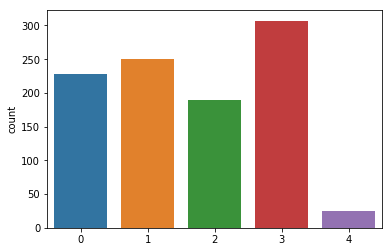

In [33]:
sns.countplot(Z_train[Z_train!=-1])

In [18]:
y_obs.shape

(98980, 1960)

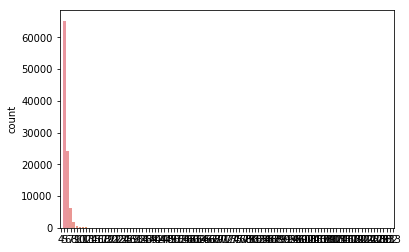

Minimum annotations in a example:  4
Maximum annotations in a example:  133
T data (expected value):  5.75140432410588
Graphics of T weights


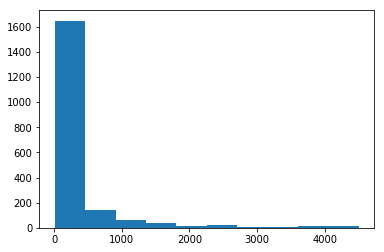

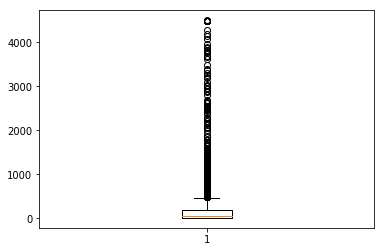

Minimum annotations by an annotator:  8
Maximum annotations by an annotator:  4506
Mean annotations by an annotator:  290.44591836734696


In [27]:
#graphics and distribution? what is T_data
T_weights = np.sum(y_obs != -1,axis=0) #distribucion de anotaciones
N_ann = np.sum(y_obs != -1,axis=1) #distribucion de anotaciones con este valor

N, T = y_obs.shape
Kl = np.max(y_obs)+1

sns.countplot(N_ann)
plt.show()
print("Minimum annotations in a example: ",N_ann.min())
print("Maximum annotations in a example: ",N_ann.max())
print("T data (expected value): ",N_ann.mean())

print("Graphics of T weights")
plt.hist(T_weights)
plt.show()

plt.boxplot(T_weights)
plt.show()
print("Minimum annotations by an annotator: ",T_weights.min())
print("Maximum annotations by an annotator: ",T_weights.max())
print("Mean annotations by an annotator: ",T_weights.mean())

Representation for MV in 5.267546 sec
Estimation MV in 0.007917 sec
Normalized entropy (0-1) of repeats annotations: 0.26250069754851657


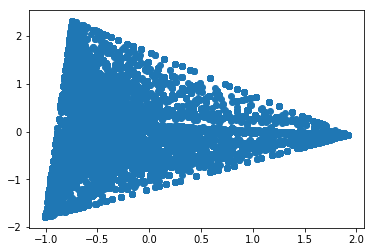

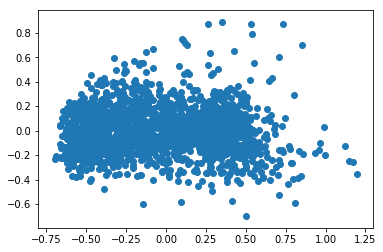

In [31]:
from sklearn.metrics import f1_score
label_I = LabelInference(y_obs,1,type_inf = 'mv')
mv_onehot, conf = label_I.mv_labels('classes')
#print("ACC MV on train:",np.mean(mv_onehot==Z_data))
#print("F1 MV on train:",f1_score(Z_data,mv_onehot,average="micro"))


mv_soft = majority_voting(label_I.y_obs_repeat,repeats=True,probas=True) 
aux = []
for example in mv_soft:
    aux.append(entropy(example)/np.log(Kl))
print("Normalized entropy (0-1) of repeats annotations:",np.mean(aux))

predicted = np.clip(mv_soft, keras.backend.epsilon(), 1.)
data_to_cluster = []
for i in range(mv_soft.shape[0]):
    for j in range(mv_soft.shape[1]):
        ob = np.tile(keras.backend.epsilon(), mv_soft.shape[1])
        ob[j] = 1
        true = np.clip(predicted[i],keras.backend.epsilon(),1.)      
        f_l = distance_function(true, ob)  #funcion de distancia o similaridad
        data_to_cluster.append(f_l)  
data_to_cluster = np.asarray(data_to_cluster)
model = PCA(n_components=min(3,mv_soft.shape[1]) ) 
data_to_cluster = model.fit_transform(data_to_cluster)

std = StandardScaler(with_mean=True,with_std=True)
data_to_plot = std.fit_transform(data_to_cluster)
plt.scatter(data_to_plot[:,0],data_to_plot[:,1])
plt.show()


Y_ann_train, T_idx = set_representation(y_obs,"onehotvar")
from code.MixtureofGroups import *
conf_mat, conf_mat_norm  = build_conf_Yvar(Y_ann_train, T_idx, mv_soft.argmax(axis=-1))

A_rep = conf_mat_norm.reshape(conf_mat_norm.shape[0], Kl**2) #flatten

from sklearn.decomposition import PCA
model = PCA(2)
aux_pca = model.fit_transform(A_rep)
plt.scatter(aux_pca[:,0],aux_pca[:,1])
plt.show()

#### opcion 2 ocupar solo los de crowdflower (son mil)

In [45]:
df_ann = pd.read_csv(folder+"github/weather-non-agg-DFE.csv")
df_ann.head()

,_unit_id,_created_at,_canary,_id,_started_at,_channel,_trust,_worker_id,_country,_region,_city,_ip,what_emotion_does_the_author_express_specifically_about_the_weather,gold_answer,tweet_id,tweet_text
0,314960380,8/23/2013 23:57:30,NaN,1038995940,8/23/2013 23:57:20,probux,1.0000,18939994,PRT,14,Vila Franca De Xira,2.83.187.82,Neutral / author is just sharing information,NaN,81990560,Grilling kabobs on the grill last night was am...
1,314960380,8/24/2013 00:09:18,NaN,1039004532,8/24/2013 00:09:05,eup_slw,0.4658,19028457,DEU,02,Holzkirchen,188.192.44.105,Negative,NaN,81990560,Grilling kabobs on the grill last night was am...
2,314960380,8/24/2013 00:09:31,NaN,1039004700,8/24/2013 00:08:14,clixsense,0.7630,14400603,SRB,NaN,NaN,178.221.70.117,Positive,NaN,81990560,Grilling kabobs on the grill last night was am...
3,314960380,8/24/2013 00:11:55,NaN,1039006547,8/24/2013 00:11:13,clixsense,0.6429,17475684,IND,02,Tirupati,117.204.49.167,Positive,NaN,81990560,Grilling kabobs on the grill last night was am...
4,314960380,8/24/2013 00:13:22,NaN,1039007700,8/24/2013 00:11:50,stuffpoint,0.9286,11800825,SWE,10,Avesta,83.253.207.185,Positive,NaN,81990560,Grilling kabobs on the grill last night was am...


In [49]:
labels_cat = {"Negative":0, "Neutral / author is just sharing information":1, "Positive":2, 
              "Tweet not related to weather condition":3,"I can't tell":4 }

In [51]:
####### GUARDAR DATA
data_id = {}
worker_id = {}
contador_data, contador_work = 0,0
for row in df_ann.values:
    inp_id = row[-2]
    if inp_id not in data_id:
        data_id[inp_id] = contador_data
        contador_data+=1        
    work_id = row[7]
    if work_id not in worker_id:
        worker_id[work_id] = contador_work
        contador_work+=1  
        
#Z_train = np.ones(contador_data, dtype='int16')*-1
texts_train = [ [] for _ in range(contador_data)]

y_obs = np.ones((contador_data,contador_work),dtype='int16')*-1
for row in df_ann.values:
    y_obs[data_id[row[-2]], worker_id[row[7]]] = labels_cat[row[-4]]
    texts_train[data_id[row[-2]]] = row[-1]
    
    
        
#np.savetxt("./Sentiment/answers.txt", y_obs,delimiter=' ', fmt='%d')
#np.savetxt("./Sentiment/sent_train.txt", Z_train,delimiter=' ', fmt='%d')
#np.savetxt("./Sentiment/sent_test.txt", Z_test,delimiter=' ', fmt='%d')
#with open("./Sentiment/texts_train.txt", 'w') as fp:
#    fp.write("\n".join(texts_train))
#with open("./Sentiment/texts_test.txt", 'w') as fp:
#    fp.write("\n".join(texts_test))   
y_obs.shape

(1000, 102)

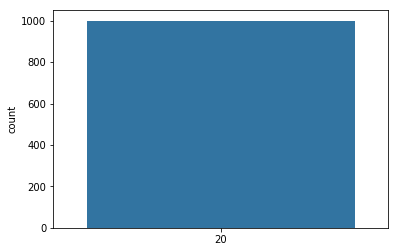

Minimum annotations in a example:  20
Maximum annotations in a example:  20
T data (expected value):  20.0
Graphics of T weights


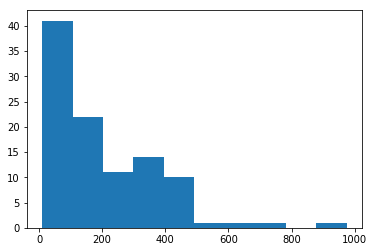

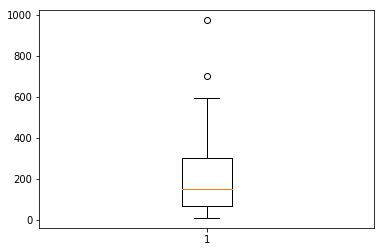

Minimum annotations by an annotator:  10
Maximum annotations by an annotator:  974
Mean annotations by an annotator:  196.07843137254903


In [52]:
#graphics and distribution? what is T_data
T_weights = np.sum(y_obs != -1,axis=0) #distribucion de anotaciones
N_ann = np.sum(y_obs != -1,axis=1) #distribucion de anotaciones con este valor

N, T = y_obs.shape
Kl = np.max(y_obs)+1

sns.countplot(N_ann)
plt.show()
print("Minimum annotations in a example: ",N_ann.min())
print("Maximum annotations in a example: ",N_ann.max())
print("T data (expected value): ",N_ann.mean())

print("Graphics of T weights")
plt.hist(T_weights)
plt.show()

plt.boxplot(T_weights)
plt.show()
print("Minimum annotations by an annotator: ",T_weights.min())
print("Maximum annotations by an annotator: ",T_weights.max())
print("Mean annotations by an annotator: ",T_weights.mean())

### Semeval 2013 / task2 - B

https://www.cs.york.ac.uk/semeval-2013/task2.html

* Sentiment Analysis in Twitter

* positive|negative|neutral|objective


In [2]:
folder = "../Semeval/"
df_ann = pd.read_csv(folder+"tweeti-b.dist.tsv", sep='\t', header=None, names =["SID","UID","sent"])

df_ann = pd.read_csv(folder+"Tweets/texts_train.txt", sep='\t', header=None, names =["SID","UID","sent","text"])
#df_gt = pd.read_csv(folder+"cf-gold/reference_100%.csv")
df_ann.head()

,SID,UID,sent,text
0,264183816548130816,15140428,positive,Gas by my house hit $3.39!!!! I'm going to Cha...
1,264249301910310912,18516728,negative,Iranian general says Israel's Iron Dome can't ...
2,264105751826538497,147088367,positive,with J Davlar 11th. Main rivals are team Polan...
3,264094586689953794,332474633,negative,"Talking about ACT's && SAT's, deciding where I..."
4,254941790757601280,557103111,negative,"They may have a SuperBowl in Dallas, but Dalla..."


In [3]:
labels_cat = {"negative":0, "neutral":1, "positive":2, 
              "objective":3,"objective-OR-neutral":4 }
labels_cat

{'negative': 0,
 'neutral': 1,
 'objective': 3,
 'objective-OR-neutral': 4,
 'positive': 2}

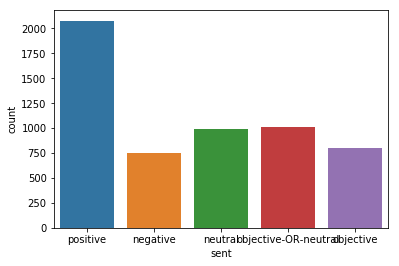

In [5]:
sns.countplot(df_ann["sent"])

In [4]:
####### GUARDAR DATA
data_id = {}
worker_id = {}
contador_data, contador_work = 0,0
for row in df_ann.values:
    inp_id = row[0]
    if inp_id not in data_id:
        data_id[inp_id] = contador_data
        contador_data+=1        
    #work_id = contador_work #row[1]
    #if work_id not in worker_id:
    #    worker_id[work_id] = contador_work
    #    contador_work+=1  
        
#y_obs = np.ones((contador_data,df_ann.shape[0]),dtype='int16')*-1
#for row in df_ann.values:
#    work_id = contador_work #row[1]
#    y_obs[data_id[row[0]],work_id] = labels_cat[row[2]]
#    contador_work+=1
    
Z_data = np.ones((contador_data),dtype='int16')*-1
texts_data = [ [] for _ in range(contador_data)]
for row in df_ann.values:
    Z_data[data_id[row[0]]] = labels_cat[row[2]]
    texts_data[data_id[row[0]]] = row[-1].replace("\n", ' ')

        
#np.savetxt("./Sentiment/answers.txt", y_obs,delimiter=' ', fmt='%d')
np.savetxt("./Sentiment/Semeval/sent_data.txt", Z_data,delimiter=' ', fmt='%d')
with open("./Sentiment/Semeval/texts_data.txt", 'w') as fp:
    fp.write("\n".join(texts_data))
#with open("./Sentiment/texts_test.txt", 'w') as fp:
#    fp.write("\n".join(texts_test))  
#y_obs.shape

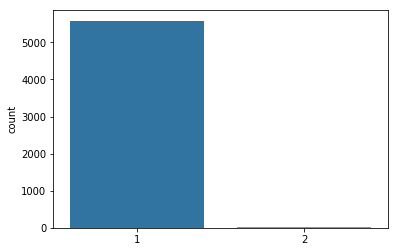

Minimum annotations in a example:  1
Maximum annotations in a example:  2
T data (expected value):  1.0044571224817258
Graphics of T weights


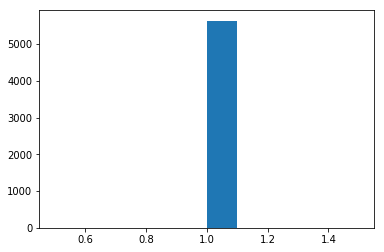

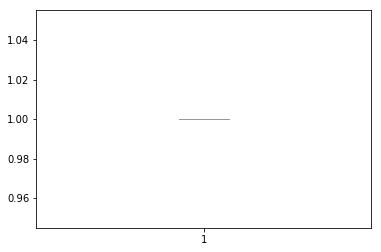

Minimum annotations by an annotator:  1
Maximum annotations by an annotator:  1
Mean annotations by an annotator:  1.0


In [83]:
#graphics and distribution? what is T_data
T_weights = np.sum(y_obs != -1,axis=0) #distribucion de anotaciones
N_ann = np.sum(y_obs != -1,axis=1) #distribucion de anotaciones con este valor

N, T = y_obs.shape
Kl = np.max(y_obs)+1

sns.countplot(N_ann)
plt.show()
print("Minimum annotations in a example: ",N_ann.min())
print("Maximum annotations in a example: ",N_ann.max())
print("T data (expected value): ",N_ann.mean())

print("Graphics of T weights")
plt.hist(T_weights)
plt.show()

plt.boxplot(T_weights)
plt.show()
print("Minimum annotations by an annotator: ",T_weights.min())
print("Maximum annotations by an annotator: ",T_weights.max())
print("Mean annotations by an annotator: ",T_weights.mean())

### Airline Sentiment
A sentiment analysis job about the problems of each major U.S. airline. Twitter data was scraped from February of 2015 and contributors were asked to first classify positive, negative, and neutral tweets, followed by categorizing negative reasons (such as “late flight” or “rude service”).

links
> https://www.figure-eight.com/data-for-everyone/  
> https://github.com/naimulhuq/Capstone

In [2]:
folder = "../Nuevos/AirLine Sentiment/"
df_ann = pd.read_csv(folder+"Airline-Full-Non-Ag-DFE-Sentiment.csv")
df_ann.head()

,_unit_id,_created_at,_golden,_id,_missed,_started_at,_tainted,_channel,_trust,_worker_id,...,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone
0,681448150,2/25/2015 04:52:40,False,1575073003,NaN,2/25/2015 04:49:12,False,elite,0.8108,31110645,...,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35,5.703060e+17,NaN,Eastern Time (US & Canada)
1,681448150,2/25/2015 05:22:10,False,1575093916,NaN,2/25/2015 05:19:59,False,prodege,0.8919,1908948,...,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35,5.703060e+17,NaN,Eastern Time (US & Canada)
2,681448150,2/25/2015 05:24:40,False,1575095606,NaN,2/25/2015 05:20:10,False,clixsense,0.7222,31396033,...,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35,5.703060e+17,NaN,Eastern Time (US & Canada)
3,681448153,2/25/2015 01:43:24,False,1574913129,NaN,2/25/2015 01:40:59,False,neodev,0.8966,31346116,...,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15,5.703010e+17,NaN,Pacific Time (US & Canada)
4,681448153,2/25/2015 01:43:34,False,1574913225,NaN,2/25/2015 01:40:56,False,neodev,0.8108,31452413,...,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15,5.703010e+17,NaN,Pacific Time (US & Canada)


In [7]:
#cat_map = {e:i for i,e in enumerate(df_ann["airline_sentiment"].unique())}
cat_map = {"negative":0, "neutral":1,"positive":2}
cat_map[np.nan] = -1 #for ground truth
print(cat_map)
df_ann[["airline_sentiment","negativereason"]]

{nan: -1, 'neutral': 1, 'positive': 2, 'negative': 0}


,airline_sentiment,negativereason
0,neutral,NaN
1,neutral,NaN
2,neutral,NaN
3,positive,NaN
4,neutral,NaN
5,negative,badflight
6,positive,NaN
7,neutral,NaN
8,neutral,NaN
9,negative,CSProblem


In [3]:
#second clasification?
df_ann["negativereason"].unique()

array([nan, 'badflight', 'CSProblem', 'canttell', 'late', 'airplanestaff',
       'booking', 'lostluggae', 'cancel', 'damagedluggage', 'longlines'],
      dtype=object)

In [23]:
####### GUARDAR DATA
data_id = {}
worker_id = {}
contador_data, contador_work = 0,0
for i in range(df_ann.shape[0]):
    inp_id = df_ann["_unit_id"].iloc[i]
    if inp_id not in data_id:
        data_id[inp_id] = contador_data
        contador_data+=1        
    work_id = df_ann["_worker_id"].iloc[i]
    if work_id not in worker_id:
        worker_id[work_id] = contador_work
        contador_work+=1  
    
y_obs = np.ones((contador_data,contador_work),dtype='int16')*-1
Z_train = np.ones(contador_data, dtype='int16')*-1
texts_train = [ [] for _ in range(contador_data)]
for i in range(df_ann.shape[0]):
    inp_id = df_ann["_unit_id"].iloc[i]
    work_id = df_ann["_worker_id"].iloc[i]
    y_obs[data_id[inp_id], worker_id[work_id]] = cat_map[df_ann["airline_sentiment"].iloc[i]]
    if Z_train[data_id[inp_id]] == -1: 
        Z_train[data_id[inp_id]] = cat_map[df_ann["airline_sentiment_gold"].iloc[i]]
        texts_train[data_id[inp_id]] = df_ann["text"].iloc[i].replace("\n",'')
print("ground truth data: ",np.sum(Z_train!=-1))

        
np.savetxt("./AirlineSentiment/answers.txt", y_obs,delimiter=' ', fmt='%d')
np.savetxt("./AirlineSentiment/sent_train.txt", Z_train,delimiter=' ', fmt='%d')
#np.savetxt("./AirlineSentiment/sent_test.txt", Z_test,delimiter=' ', fmt='%d')
with open("./AirlineSentiment/texts_train.txt", 'w') as fp:
    fp.write("\n".join(texts_train))
    
#with open("./Sentiment/texts_test.txt", 'w') as fp:
#    fp.write("\n".join(texts_test))   

y_obs.shape

ground truth data:  80


(14680, 503)

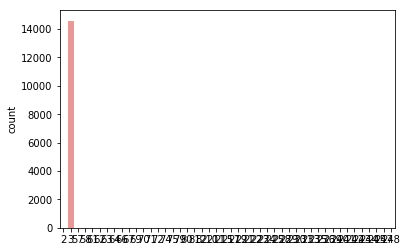

Minimum annotations in a example:  2
Maximum annotations in a example:  248
T data (expected value):  3.799931880108992
Graphics of T weights


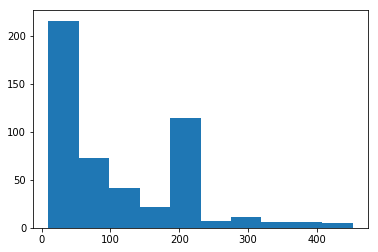

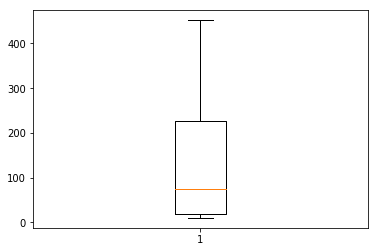

Minimum annotations by an annotator:  10
Maximum annotations by an annotator:  452
Mean annotations by an annotator:  110.90059642147118


In [41]:
#graphics and distribution? what is T_data
T_weights = np.sum(y_obs != -1,axis=0) #distribucion de anotaciones
N_ann = np.sum(y_obs != -1,axis=1) #distribucion de anotaciones con este valor

N, T = y_obs.shape
Kl = np.max(y_obs)+1

sns.countplot(N_ann)
plt.show()
print("Minimum annotations in a example: ",N_ann.min())
print("Maximum annotations in a example: ",N_ann.max())
print("T data (expected value): ",N_ann.mean())

print("Graphics of T weights")
plt.hist(T_weights)
plt.show()

plt.boxplot(T_weights)
plt.show()
print("Minimum annotations by an annotator: ",T_weights.min())
print("Maximum annotations by an annotator: ",T_weights.max())
print("Mean annotations by an annotator: ",T_weights.mean())

Representation for MV in 0.470570 sec
Estimation MV in 0.002305 sec
Normalized entropy (0-1) of repeats annotations: 0.1724012327296246


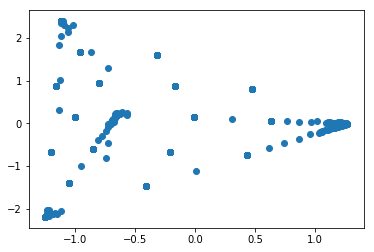

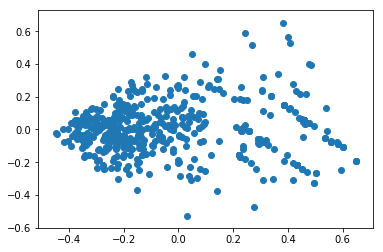

In [42]:
from sklearn.metrics import f1_score
label_I = LabelInference(y_obs,1,type_inf = 'mv')
mv_onehot, conf = label_I.mv_labels('classes')
#print("ACC MV on train:",np.mean(mv_onehot==Z_data))
#print("F1 MV on train:",f1_score(Z_data,mv_onehot,average="micro"))


mv_soft = majority_voting(label_I.y_obs_repeat,repeats=True,probas=True) 
aux = []
for example in mv_soft:
    aux.append(entropy(example)/np.log(Kl))
print("Normalized entropy (0-1) of repeats annotations:",np.mean(aux))

predicted = np.clip(mv_soft, keras.backend.epsilon(), 1.)
data_to_cluster = []
for i in range(mv_soft.shape[0]):
    for j in range(mv_soft.shape[1]):
        ob = np.tile(keras.backend.epsilon(), mv_soft.shape[1])
        ob[j] = 1
        true = np.clip(predicted[i],keras.backend.epsilon(),1.)      
        f_l = distance_function(true, ob)  #funcion de distancia o similaridad
        data_to_cluster.append(f_l)  
data_to_cluster = np.asarray(data_to_cluster)
model = PCA(n_components=min(3,mv_soft.shape[1]) ) 
data_to_cluster = model.fit_transform(data_to_cluster)

std = StandardScaler(with_mean=True,with_std=True)
data_to_plot = std.fit_transform(data_to_cluster)
plt.scatter(data_to_plot[:,0],data_to_plot[:,1])
plt.show()


Y_ann_train, T_idx = set_representation(y_obs,"onehotvar")
from code.MixtureofGroups import *
conf_mat, conf_mat_norm  = build_conf_Yvar(Y_ann_train, T_idx, mv_soft.argmax(axis=-1))

A_rep = conf_mat_norm.reshape(conf_mat_norm.shape[0], Kl**2) #flatten

from sklearn.decomposition import PCA
model = PCA(2)
aux_pca = model.fit_transform(A_rep)
plt.scatter(aux_pca[:,0],aux_pca[:,1])
plt.show()

### Plutchnik Emotion
Contributors looked at a single sentence and rated its emotional content based on Plutchik’s wheel of emotions. 18 emotional choices were presented to contributors for grading.
> https://www.figure-eight.com/data-for-everyone/

In [46]:
folder = "../Nuevos/PlutchnikEmotion/"
df_ann = pd.read_csv(folder+"plutchik-wheel-full-DFE.csv")
df_ann.head()

,_unit_id,_created_at,_golden,_id,_missed,_started_at,_tainted,_channel,_trust,_worker_id,_country,_region,_city,_ip,emotion,emotion_gold,id,idiom_id,sentence
0,731671736,6/8/2015 15:27:42,False,1655597414,NaN,6/8/2015 15:26:09,False,instagc,0.6667,28524232,CAN,ON,Scarborough,99.244.116.246,Neutral,NaN,1,1,How much of the forecast was genuine and how m...
1,731671736,6/8/2015 15:37:09,False,1655611318,NaN,6/8/2015 15:35:14,False,tremorgames,1.0000,29121923,IRL,16,Limerick,95.45.138.162,Surprise,NaN,1,1,How much of the forecast was genuine and how m...
2,731671736,6/8/2015 15:39:26,False,1655614903,NaN,6/8/2015 15:35:53,False,points4rewards,1.0000,28755767,USA,VA,Chester,68.57.118.32,Anger,NaN,1,1,How much of the forecast was genuine and how m...
3,731671736,6/8/2015 15:44:22,False,1655622353,NaN,6/8/2015 15:38:02,False,neodev,1.0000,32108888,USA,CA,San Jose,50.117.41.210,Optimism,NaN,1,1,How much of the forecast was genuine and how m...
4,731671736,6/8/2015 16:10:09,False,1655661485,NaN,6/8/2015 16:05:56,False,points4rewards,0.8333,20113482,USA,CA,Pasadena,205.144.165.253,Neutral,NaN,1,1,How much of the forecast was genuine and how m...


In [47]:
cat_map = {e:i for i,e in enumerate(df_ann["emotion"].unique())}
cat_map[np.nan] = -1
print(cat_map)

{nan: -1, 'Ambiguous': 6, 'Aggression': 10, 'Remorse': 16, 'Anger': 2, 'Awe': 15, 'Contempt': 13, 'Optimism': 3, 'Trust': 8, 'Fear': 17, 'Neutral': 0, 'Surprise': 1, 'Love': 4, 'Joy': 12, 'Submission': 5, 'Sadness': 9, 'Anticipation': 7, 'Disapproval': 11, 'Disgust': 14}


In [50]:
df_ann["emotion_gold"].unique()

array([nan,
       'Aggression\nAnger\nAwe\nContempt\nDisapproval\nDisgust\nLove\nNeutral',
       'Aggression\nAnger\nContempt\nDisapproval\nDisgust',
       'Aggression\nAnger\nContempt\nDisapproval\nDisgust\nRemorse\nSadness',
       'Anger\nDisapproval\nLove\nNeutral\nSadness',
       'Joy\nOptimism\nSurprise', 'Ambiguous\nNeutral', 'Joy\nOptimism',
       'Aggression\nAmbiguous\nAnger\nContempt\nDisapproval\nDisgust\nNeutral\nRemorse\nSadness',
       'Aggression\nAnger\nContempt\nDisapproval\nDisgust\nSadness',
       'Aggression\nAnger\nContempt\nDisapproval\nRemorse',
       'Ambiguous\nAnticipation\nContempt\nDisapproval\nFear\nLove\nOptimism\nSurprise\nTrust',
       'Ambiguous\nNeutral\nOptimism\nTrust',
       'Aggression\nAnger\nContempt\nDisapproval\nDisgust\nRemorse',
       'Aggression\nAnger\nDisapproval\nFear\nSurprise',
       'Aggression\nAnger', 'Optimism',
       'Anger\nAnticipation\nContempt\nDisapproval\nDisgust\nFear\nRemorse\nSadness',
       'Awe\nFear\nSurp

In [52]:
####### GUARDAR DATA
data_id = {}
worker_id = {}
contador_data, contador_work = 0,0
for i in range(df_ann.shape[0]):
    inp_id = df_ann["_unit_id"].iloc[i]
    if inp_id not in data_id:
        data_id[inp_id] = contador_data
        contador_data+=1        
    work_id = df_ann["_worker_id"].iloc[i]
    if work_id not in worker_id:
        worker_id[work_id] = contador_work
        contador_work+=1  
    
y_obs = np.ones((contador_data,contador_work),dtype='int16')*-1
Z_train = np.ones(contador_data, dtype='int16')*-1
texts_train = [ [] for _ in range(contador_data)]
for i in range(df_ann.shape[0]):
    inp_id = df_ann["_unit_id"].iloc[i]
    work_id = df_ann["_worker_id"].iloc[i]
    y_obs[data_id[inp_id], worker_id[work_id]] = cat_map[df_ann["emotion"].iloc[i]]
    if Z_train[data_id[inp_id]] == -1: 
        #how to choose GT??
        try:
            Z_train[data_id[inp_id]] = cat_map[df_ann["emotion_gold"].iloc[i]]
        except:
            Z_train[data_id[inp_id]] = cat_map[df_ann["emotion_gold"].iloc[i].split("\n")[0]]
        texts_train[data_id[inp_id]] = df_ann["sentence"].iloc[i]
print("ground truth data: ",np.sum(Z_train!=-1))
y_obs.shape

ground truth data:  54


(2524, 96)

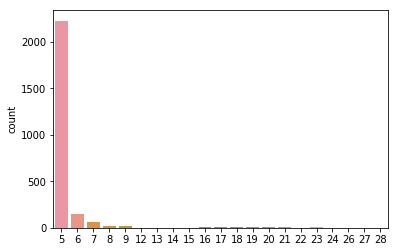

Minimum annotations in a example:  5
Maximum annotations in a example:  28
T data (expected value):  5.467908082408875
Graphics of T weights


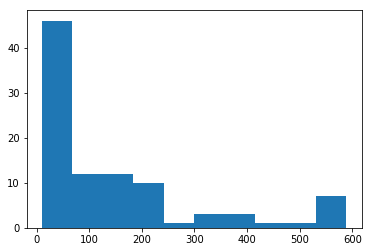

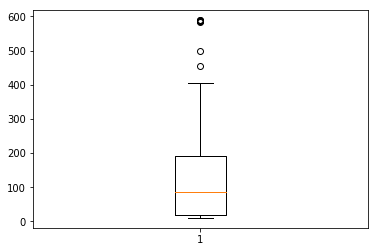

Minimum annotations by an annotator:  10
Maximum annotations by an annotator:  589
Mean annotations by an annotator:  143.76041666666666


In [53]:
#graphics and distribution? what is T_data
T_weights = np.sum(y_obs != -1,axis=0) #distribucion de anotaciones
N_ann = np.sum(y_obs != -1,axis=1) #distribucion de anotaciones con este valor

N, T = y_obs.shape
Kl = np.max(y_obs)+1

sns.countplot(N_ann)
plt.show()
print("Minimum annotations in a example: ",N_ann.min())
print("Maximum annotations in a example: ",N_ann.max())
print("T data (expected value): ",N_ann.mean())

print("Graphics of T weights")
plt.hist(T_weights)
plt.show()

plt.boxplot(T_weights)
plt.show()
print("Minimum annotations by an annotator: ",T_weights.min())
print("Maximum annotations by an annotator: ",T_weights.max())
print("Mean annotations by an annotator: ",T_weights.mean())

Representation for MV in 0.110303 sec
Estimation MV in 0.000777 sec
Normalized entropy (0-1) of repeats annotations: 0.38081940435115635


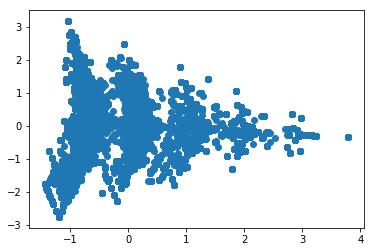

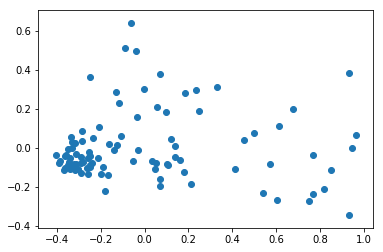

In [55]:
from sklearn.metrics import f1_score
label_I = LabelInference(y_obs,1,type_inf = 'mv')
mv_onehot, conf = label_I.mv_labels('classes')
#print("ACC MV on train:",np.mean(mv_onehot==Z_data))
#print("F1 MV on train:",f1_score(Z_data,mv_onehot,average="micro"))


mv_soft = majority_voting(label_I.y_obs_repeat,repeats=True,probas=True) 
aux = []
for example in mv_soft:
    aux.append(entropy(example)/np.log(Kl))
print("Normalized entropy (0-1) of repeats annotations:",np.mean(aux))

predicted = np.clip(mv_soft, keras.backend.epsilon(), 1.)
data_to_cluster = []
for i in range(mv_soft.shape[0]):
    for j in range(mv_soft.shape[1]):
        ob = np.tile(keras.backend.epsilon(), mv_soft.shape[1])
        ob[j] = 1
        true = np.clip(predicted[i],keras.backend.epsilon(),1.)      
        f_l = distance_function(true, ob)  #funcion de distancia o similaridad
        data_to_cluster.append(f_l)  
data_to_cluster = np.asarray(data_to_cluster)
model = PCA(n_components=min(3,mv_soft.shape[1]) ) 
data_to_cluster = model.fit_transform(data_to_cluster)

std = StandardScaler(with_mean=True,with_std=True)
data_to_plot = std.fit_transform(data_to_cluster)
plt.scatter(data_to_plot[:,0],data_to_plot[:,1])
plt.show()


Y_ann_train, T_idx = set_representation(y_obs,"onehotvar")
from code.MixtureofGroups import *
conf_mat, conf_mat_norm  = build_conf_Yvar(Y_ann_train, T_idx, mv_soft.argmax(axis=-1))

A_rep = conf_mat_norm.reshape(conf_mat_norm.shape[0], Kl**2) #flatten

from sklearn.decomposition import PCA
model = PCA(2)
aux_pca = model.fit_transform(A_rep)
plt.scatter(aux_pca[:,0],aux_pca[:,1])
plt.show()

### Company URL
A data set where business names were matched with URLs/homepages for the named businesses.
Contributors were asked to visit a provided website and determine if the site matched a given company name. They then categorized the businesses according to the following criteria:

    Automotive
    Consumer Packaged Goods
    Financial Services
    Retail
    Travel
    Other

Data set includes the given company name, URL, and categorization of each business.
> https://www.figure-eight.com/data-for-everyone/

In [2]:
folder = "../Nuevos/CompanyURL//"
df_ann = pd.read_csv(folder+"company-categorization-non-ag-DFE.csv", low_memory=False)
df_ann.head()

,_unit_id,_created_at,_golden,_canary,_id,_missed,_started_at,_tainted,_channel,_trust,...,google1_correct_website,google1_correct_website_found,google1_correct_website_found_gold,google1_correct_website_foundconfidence,google1_correct_website_gold,google1_correct_website_worker_input,google1_correct_website_worker_inputconfidence,google1_correct_websiteconfidence,website,website_match_yn_gold
0,474823173,6/4/2014 23:13:15,False,NaN,1289157499,NaN,6/4/2014 23:10:56,False,eup_slw,0.6667,...,http://central1.com/,yes,NaN,1.00,NaN,/www.central1.com,0.6538,0.6538,NaN,NaN
1,474823173,6/4/2014 23:57:33,False,NaN,1289177999,NaN,6/4/2014 23:55:19,False,neodev,0.7500,...,http://central1.com/,yes,NaN,1.00,NaN,/www.central1.com,0.6538,0.6538,NaN,NaN
2,474823173,6/5/2014 00:29:34,False,NaN,1289197449,NaN,6/5/2014 00:26:09,False,neodev,0.7838,...,http://central1.com/,yes,NaN,1.00,NaN,/www.central1.com,0.6538,0.6538,NaN,NaN
3,474823174,6/4/2014 22:32:17,False,NaN,1289128970,NaN,6/4/2014 22:31:14,False,neodev,0.8200,...,http://ad-agents.com/,yes,NaN,0.64,NaN,ad-agents.com/,0.2304,0.3600,http://www.ad-agents.com/kontakt/,NaN
4,474823174,6/4/2014 22:32:59,False,NaN,1289129505,NaN,6/4/2014 22:30:23,False,neodev,0.7826,...,http://ad-agents.com/,yes,NaN,0.64,NaN,ad-agents.com/,0.2304,0.3600,http://www.ad-agents.com/kontakt/,NaN


In [3]:
df_ann[df_ann["website_match_yn"] == "website_no_match"].iloc[:,10:]

,_worker_id,_country,_region,_city,_ip,business_category,description_available,website_match_yn,orig__canary,orig__golden,...,google1_correct_website,google1_correct_website_found,google1_correct_website_found_gold,google1_correct_website_foundconfidence,google1_correct_website_gold,google1_correct_website_worker_input,google1_correct_website_worker_inputconfidence,google1_correct_websiteconfidence,website,website_match_yn_gold
189,17628770,USA,TX,Porter,75.108.233.84,NaN,NaN,website_no_match,NaN,False,...,http://flirtfair.de.incom.pk/,yes,NaN,0.6538,NaN,flirtfair.de.incom.pk,0.2263,0.3462,NaN,NaN
374,14265684,HUN,03,Gyula,82.150.58.12,NaN,NaN,website_no_match,NaN,False,...,http://bar.com/,yes,NaN,1.0000,NaN,http://bar.com/,0.6763,1.0000,bar.com,NaN
2373,14265684,HUN,03,Gyula,82.150.58.12,NaN,NaN,website_no_match,NaN,False,...,http://alternergy.co.uk/,yes,NaN,1.0000,NaN,http://www.alternergy.co.uk/,1.0000,1.0000,www.alternergy.co.uk,NaN
2454,27393376,BRA,07,Brasília,189.6.108.235,NaN,NaN,website_no_match,NaN,False,...,http://amtrak.com/,yes,NaN,1.0000,NaN,http://www.amtrak.com/home,0.7083,0.7083,www.amtrak.com,NaN
2488,25603852,ROU,17,Craiova,86.126.60.142,NaN,NaN,website_no_match,NaN,False,...,http://ansira.com/,yes,NaN,0.6923,NaN,http://www.ansira.com/,0.2396,0.6923,http://www.ansira.com/,NaN
3088,27089497,VNM,44,Hanoi,171.226.141.182,NaN,NaN,website_no_match,NaN,False,...,http://blair.com/,yes,NaN,1.0000,NaN,http://www.blair.com/,0.6358,1.0000,www.blair.com,NaN
3204,25747978,PRT,09,Faro,85.246.203.93,NaN,NaN,website_no_match,NaN,False,...,http://borgess.com/default.aspx,yes,NaN,1.0000,NaN,http://www.borgess.com/default.aspx,1.0000,1.0000,www.borgess.com,NaN
3356,24907909,ROU,09,Brasov,188.27.57.121,NaN,NaN,website_no_match,NaN,False,...,http://burgenland.at/,yes,NaN,1.0000,NaN,http://www.burgenland.at/,0.6667,0.6667,NaN,NaN
4151,19982940,GBR,B1,Bolton,176.253.129.25,NaN,NaN,website_no_match,NaN,False,...,http://cspire.com/,yes,NaN,1.0000,NaN,http://www.cspire.com/,1.0000,1.0000,www.cellularsouth.com,NaN
4159,25670443,MEX,30,Coatepec,189.251.59.85,NaN,NaN,website_no_match,NaN,False,...,http://ctpboston.com/,yes,NaN,0.6429,NaN,http://www.ctpboston.com/,0.4133,0.6429,ctpboston.com,NaN


In [4]:
df_ann["business_category"].fillna("Notcompany", inplace=True) #fill not website match as a class

df_ann[["business_category","website_match_yn",
       "business_name", "google1_correct_website",
       "website", "google1_correct_website_worker_input"]]

,business_category,website_match_yn,business_name,google1_correct_website,website,google1_correct_website_worker_input
0,Financial Services,website_yes_match,Central 1,http://central1.com/,NaN,/www.central1.com
1,Financial Services,website_yes_match,Central 1,http://central1.com/,NaN,/www.central1.com
2,Financial Services,website_yes_match,Central 1,http://central1.com/,NaN,/www.central1.com
3,Other,website_yes_match,ad agents GmbH Hamburg - Germany,http://ad-agents.com/,http://www.ad-agents.com/kontakt/,ad-agents.com/
4,Retail,website_yes_match,ad agents GmbH Hamburg - Germany,http://ad-agents.com/,http://www.ad-agents.com/kontakt/,ad-agents.com/
5,Financial Services,website_yes_match,ad agents GmbH Hamburg - Germany,http://ad-agents.com/,http://www.ad-agents.com/kontakt/,ad-agents.com/
6,Other,website_yes_match,ad tech | iMedia,http://ad-tech.com/,NaN,ad-tech.com
7,Other,website_yes_match,ad tech | iMedia,http://ad-tech.com/,NaN,ad-tech.com
8,Other,website_yes_match,ad tech | iMedia,http://ad-tech.com/,NaN,ad-tech.com
9,Other,website_yes_match,AddRev,http://addrev.com/,NaN,addrev.com/


In [5]:
cat_map = {e:i for i,e in enumerate(df_ann["business_category"].unique())}
cat_map[np.nan] = -1 
print(cat_map) 

{nan: -1, 'Retail': 2, 'Other': 1, 'Auto': 6, 'Notcompany': 5, 'Travel': 4, 'Financial Services': 0, 'CPG': 3}


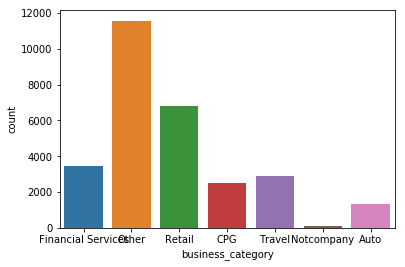

In [6]:
sns.countplot(df_ann["business_category"])

In [7]:
####### GUARDAR DATA
data_id = {}
worker_id = {}
contador_data, contador_work = 0,0
for i in range(df_ann.shape[0]):
    inp_id = df_ann["_unit_id"].iloc[i]
    if inp_id not in data_id:
        data_id[inp_id] = contador_data
        contador_data+=1        
    work_id = df_ann["_worker_id"].iloc[i]
    if work_id not in worker_id:
        worker_id[work_id] = contador_work
        contador_work+=1  
    
y_obs = np.ones((contador_data,contador_work),dtype='int16')*-1
Z_train = np.ones(contador_data, dtype='int16')*-1
Z_test = []
urls_train = [ [] for _ in range(contador_data)]
urls_trainB = [ [] for _ in range(contador_data)]
for i in range(df_ann.shape[0]):
    inp_id = df_ann["_unit_id"].iloc[i]
    work_id = df_ann["_worker_id"].iloc[i]
    y_obs[data_id[inp_id], worker_id[work_id]] = cat_map[df_ann["business_category"].iloc[i]]
    if Z_train[data_id[inp_id]] == -1: 
        Z_train[data_id[inp_id]] = cat_map[df_ann["business_category_gold"].iloc[i]]
        urls_train[data_id[inp_id]] = df_ann["google1_correct_website"].iloc[i]
        urls_trainB[data_id[inp_id]] = df_ann["website"].iloc[i]
    
print("ground truth data: ",np.sum(Z_train!=-1))
y_obs.shape

ground truth data:  177


(7335, 837)

In [8]:
import urllib, requests, bs4
blacklist = [
    '[document]',
    'noscript',
    'header',
    'html',
    'meta',
    'head', 
    'input',
    'script',
    'style' ,
    'span',
    'button'
    #eliinar titulos "h" o  "a?
]

#dejar solo <p>?

def clean_contenido(inf):
    text = inf.find_all(text=True)  
    output = ''
    for t in text:
        if t.parent.name not in blacklist:
            contenido = t.strip() #deja sin espacios.. esta bien??
            if len(contenido) >0:
                print("Name: %s , contenido: %s"%(t.parent.name,contenido))
                output += ' {}.'.format(contenido)
    return output

In [ ]:
texts_url = []

not_found_url = []
for i,url in enumerate(urls_train):
    try:
        page = urllib.request.urlopen(url).read()
    except:
        #try:
        #    page = requests.get(url).text
        #except:
        try:
            page = urllib.request.urlopen(urls_trainB[i]).read()
        except:
            not_found_url.append([i,url])
            continue
            
    if len(page) ==0:
        #try:
        #    page = urllib.request.urlopen(urls_trainB[i]).read()
        #except:
        #    try:
        #        page = requests.get(urls_trainB[i]).text
        #    except:
                not_found_url.append([i,url])
                continue

    soup = bs4.BeautifulSoup(page, 'html.parser')
    
    if type(soup.title) == type(None):
        not_found_url.append([i,url])
        continue
    
    content = soup.title.text.strip()
    for i in soup.body.find_all("p"): #or in all??
        for value in i.find_all(text=True):
            if value.parent.name not in blacklist and len(value.strip())>0:
                content += ' '+value.strip()  #re.sub(r'http\S+', '', i.text.strip() )
    
    if len(content) == 0:
        not_found_url.append([i,url])
        continue
    
    #head_title = soup.head.title.text.strip()
    #print("Title encontrado: ",head_title)
    #print("Otro title: ",soup.title.text.strip())
    
    #body_text = clean_contenido(soup.body)
    #body_text = soup.body.find_all("p") #cada uno ponerle.text
    print("Content found: ",content)
    texts_url.append(content)

Content found:  Home - Central 1 /At Central 1, we power financial institutions. DOWNLOAD INFO ABOUT FORGE
Content found:  Agentur für digitales Marketing | Online & Performance | ad agents GmbH mission: best performance Als führen wir unsere Kunden seit 2006 zum Erfolg. Unsere Mission: best performance. Von Beratung bis Umsetzung, national bis international, leidenschaftlich und vertrauensvoll. Starten Sie mit uns durch! SEA SEO Affiliate Social Media Advertising Display Advertising Product Data Management Amazon Services Analytics Services Sie sind auf der Suche nach einem Partner, der Sie bei der Planung und Durchführung eines effizienten und schlagkräftigen Online und Performance Marketings unterstützt? Dann sind Sie bei uns genau richtig! Von Amazon über Social Media Advertising bis zu unseren Analytics Services unterstützen wir Sie ganzheitlich oder punktuell auf Ihrer Erfolgsmission. Profitieren Sie von unserer jahrelangen Erfahrung und starten mit uns durch! Unsere Leistungen S

Content found:  Almondnet Group Adtech Pioneer Established in 1998, the AlmondNet Group is an industry leader and pioneer in privacy-friendly, targeted advertising. The parent company AlmondNet Inc., which has developed an extensive suite of industry-leading targeted advertising solutions and products, is focused on R&D and the licensing of its extensive portfolio of enabling technology and Intellectual Property covering numerous areas of the targeting landscape and ecosystem, including profile based bidding, behavioral targeting, online and offline data monetization, addressable advertising, and multi-platform advertising. The leading independent aggregator and distributor of highly granular and proprietary search, purchase-intent, life-stage, demographic, past purchase and B2B data. Datonics’ 1,000+ pre-packaged segments and unlimited number of custom keyword-derived segments facilitate the delivery of highly relevant, privacy-sensitive ads to consumers on all of their devices. Inten

Content found:  BeRepublic | Transformación Digital para Tu Negocio Creamos negocios digitales para nuestros clientes Copyright @ 2017 BeRepublic. Todos los derechos reservados.
Content found:  Best Friends for Frosting | Wholehearted, Joyful Living Calling all my busy moms and working girlfriends! Are you as obsessed with avocado toast as I am? If you’re looking for the perfect on-the-go breakfast, check out these super easy and delicious avocado toast recipes and find a great new way to start your day! Looking for an easy recipe when you’re in a pinch? Whether it’s easy dinner recipes or easy dessert recipes, these semi-homemade recipes are for you! Making a meal doesn’t have to be difficult. Use these easy recipe ideas as inspiration the next time you’re looking for something effortless!  Easy Recipes Some days, the thought of Read more If you’re all about simplicity, this one is for you sister! Celebrating the every day never has to be hard, and there are so many ways to incorporat

Content found:  BrandEden Copyright © 2019 BrandEden . All Rights Reserved. Click here to reset your password.
Content found:  CK | Independent Advertising Agency, Creative Agency, Independent Media Agency, PR Agency Too much agency work is disposable. Here today, forgotten tomorrow. But great work endures. Because at its core is a big, truth-heavy insight. And when it’s delivered with the right execution, a big truth powerfully told creates what cannot be easily stolen. A friend. Our expertise spans creative, digital, media, PR/social, analytics, UX and production. The stories behind our work. Making friends since 1898. Want to work at C-K? We’d love to hear from you.
Content found:  Carmichael Lynch | Creative Advertising Agency | Minneapolis Love. It's what makes a Subaru, a Subaru. Choose Go Jean and Gene's Awesome Adventure Road Trip This Is How We Baseball Station Domination The Power of Possible Live to the Full A Proud Winter Tradition in Minnesota Pulled from the Walls #MeetAn

Content found:  CH Distillery - Chicago's Hometown Vodka - Craft Cocktail Bar & Restaurant Latest News Jeppson's Malört becomes part of the CH family CH Spirits Spirits / Recipes / Where to Buy Distillery About Us / Distillery Tours Tasting Room Hours & Menu / Tours / Host Your Event CH Distillery has partnered with Team Us Comedy to bring you an intimate evening of stand up comedy & craft cocktails. Sip on signature drinks and watch Chicago-style comedy featuring some of the best comedians in the city. Saturday, August 03, 2019 at 7:30pm Jeppson's Malört, a bitter wormwood liquor that’s simultaneously embraced and reviled by many Chicagoans, has been acquired by the Pilsen-based CH Distillery. Since the 1970s, Malört has been distilled in Florida, though its primary market has remained Chicago. Many Malört enthusiasts would agree that the liquor’s powerful aftertaste assaults the taste buds, a phenomenon that’s ironically helped grow the brand’s popularity on social media and in Chica

Content found:  Veepee France Germany Italy England Spain Austria Switzerland Poland Denmark Belgium Luxemburg Netherlands Veepee is an international e-commerce company specialised in the flash sales industry and owner of the trademarks: vente-privee, privalia, vente-exclusive, zlotewyprzedaze, e-boutich, designer & friends.
Content found:  A Different Kind of Agency
Content found:  Gruppe Deutsche Börse - Gruppe Deutsche Börse Die Gruppe Deutsche Börse verwendet Cookies, um die Funktionalität ihrer Website zu optimieren. Mit der weiteren Nutzung der Website stimmen Sie dem Einsatz von Cookies zu. Weitere Details finden Sie in unserer Datenschutzerklärung . Peter Reitz, CEO der EEX AG, spricht über die Gründe für ihren Erfolg und ist überzeugt, dass die hohen Wachstumsraten der Vergangenheit gehalten werden können. Der iSTOXX® Global Cities of Tomorrow Select 30 Index zielt darauf ab, das Potenzial von Unternehmen zu erfassen, die vom Wandel und Wachstum von Smart Cities im digitalen Z

Content found:  Elite SEM | Digital Marketing Agency | SEM, SEO, CRO, Display, Mobile Elite SEM is an amazing company! You truly feel valued as an employee and have the autonomy to make an impact." Everyone here is passionate about what they do and it's a wonderful feeling to be surrounded by such an intelligent and motivated team. Elite SEM truly offers great lives for great people. " Elite SEM is a role model for how other companies should treat their employees." Company values and office culture are something that would be hard to copy, even in a movie. " Your personal life and happiness are a HUGE priority to management. This is the first company I've ever worked for that PROACTIVELY sought to make sure my focus was on my family when it needed to be. " Elite SEM matches 100% of an employee’s contributions, up to 4% of an employee's income. Disability, Life, Health, & matching 401k contributions. We provide all employees with the peace of mind that they are fully insured and saving 

Content found:  Fab - live your fab life. Fitness, health & wellness products for you. Take the 21-Day Life-Lift Challenge --> CLICK HERE Take the 21-Day Life-Lift Challenge --> CLICK HERE Your Cart is Empty Take the Quiz I am (still) a big fan I used to shop with Fab all the time, back in the days when it was focused on homeware. I was a little sceptical when they repositioned into wellness but I must say, I purchased some of their Yoga gear and the product quality and delivery experience was super. Susan D NYC You Will Love this Yoga Course I am lucky enough to have practiced many times with Linda, the Yoga Instructor on this course. She is best of class, so I know this course is going to be amazing. I can't wait! John L Dublin Bodyboss - Amazing Product!! The product design and function is outstanding. I am a very serious fitness person but I also travel a GREAT deal. The moment I saw the product it instantly appeared to the perfectly envisioned design... but often things don't perf

Content found:  Mobile Phone and SIM Card Deals | giffgaff Join the mobile network that gives you the control,
            flexibility and freedom you deserve. *£20 goodybag now comes with 40 GB of data, of which 20 GB can be used in the EU and selected destinations. *After 40 GB of data used you'll experience a reduced data speed of 384kbps from 8am to Midnight. You may notice that activities which require high amounts of data, like HD video streaming, will be slower. Traffic Flow applies. No contract Just great value plans Flexibility Choose the plan that suits you Super helpful Community support 24/7 Huge screen without a notch Take stunning pictures in low light The phone that doesn't just stand out, it stands apart Now with 12‑month warranty Now with 12‑month warranty Now with 12‑month warranty refurbished 12-month warranty with all refurbished phones. Get in. We believe that together, with our members, anything is possible. Get
                        involved “I was drawn to the

Content found:  Empregos e Vagas de emprego em todo o Brasil | Catho Experimente por 7 dias grátis . A gente trabalha pelo seu trabalho. Experimente por 7 dias grátis . 700 pessoas por dia encontram o trabalho com a Catho. Seja uma delas. Experimente por 7 dias grátis . 1 vaga 1 vaga 6 vagas 5 vagas 1 vaga 3 vagas Daniele Borges Lovo Malcon cesar russo Política de Privacidade
Content found:  Vacuum Cleaners | Carpet Cleaners | Hard Floor Cleaners | Hoover Welcome Click Here for an Exclusive Offer on FloorMate JET | Our NEW One-Step Hard Floor Cleaner | 5 Easy Payments & FREE Shipping! Model # BH55210 Model # BH53310 Model # FH50700
Content found:  24/7 Wall St. - Insightful Analysis and Commentary for U.S. and Global Equity Investors Posted: July 20, 2019 at 8:55 am Posted: July 20, 2019 at 8:45 am Posted: July 20, 2019 at 8:40 am Posted: July 20, 2019 at 7:25 am Posted: July 19, 2019 at 8:19 pm Posted: July 19, 2019 at 8:09 pm Posted: July 19, 2019 at 4:48 pm Posted: July 19, 2019 at 

Content found:  Ackroo - Your One Stop Shop for a Gift Card & Loyalty Program 24-hour access 24-hour access onboarding and support onboarding and support point of sale point of sale affordable affordable
Content found:  Acqua Group | A data - driven company [if lt IE 9]><script>document.createElement('video');</script><![endif] https://acquagroup.it/wp-content/uploads/2019/04/NC-Awards_Assolvenza.mp4 https://acquagroup.it/wp-content/uploads/2019/04/NC-Awards_Assolvenza.mp4 Omnichallenge® è l’approccio di comunicazione di Acqua Group, un approccio che pone il consumatore al centro della comunicazione e lo segue nel suo percorso di customer experience attraverso tutti i touchpoint, in una logica integrata, coordinata e innovativa, con l’obiettivo di conquistarlo, coinvolgerlo e fidelizzarlo. Offrire ai nostri clienti progetti di comunicazione integrata omnichannel, data-driven oriented. Crescere responsabilmente nell’interesse di tutti gli stakeholder, dagli azionisti ai dipendenti, dai 

Content found:  403 Forbidden Warum erhalte ich die Fehlermeldung Â«403 ForbiddenÂ»? Meine IP-Adresse: 200.74.111.170 Zeitstempel: 2019-07-20 23:14:28
Content found:  AdLift Media Serving top digital content to millions of people worldwide Access our highly engaged audience across multiple platforms and devices Activate campaigns across multiple locations, devices and platforms Our category-leading digital properties deliver premium content and integrated advertising solutions. Constantly fresh and unique, our web content attracts visitors from all over the world across multiple platforms. Through industry-leading content strategy, social media marketing, email marketing and SEO, our intent-driven audience is always increasing. Our web properties reach millions of visitors a month across the globe. Reach the right audience. Our audience is intent-driven, allowing you to target potential customers and reach the highest possible ROI. Our team of experienced digital marketers can deliver 

Content found:  Antenna Hungária Website-unkon cookie-kat használunk, melyek célja, hogy teljesebb körű szolgáltatást nyújtsunk látogatóink részére. Tudjon meg többet… Tovább a részletekre Tovább a részletekre Tovább a részletekre Tovább a részletekre Tovább a részletekre Tovább a részletekre Összesen 132 startup jelentkezett 29 országból az Antenna Hungária által életre hívott AHa! BrainStore vállalati akcelerációs programra. A mindiGO TV applikáción regisztrálók száma hat hónap alatt elérte a 110 ezer felhasználót. 2019. június 17. és június 30. között ELINDULT A HPE NONSTOP© ADATKÖZPONTI - INFRASTRUKTÚRÁRA ALAPOZOTT APPLICATION AS A SERVICE (AaaS) ÉS A SOFTWARE AS A SERVICE (SaaS) SZOLGÁLTATÁS Érintve: MinDig TV és MinDig TV Extra szolgáltatás csatornái - MUX A, B, C, D A munkálat ideje alatt csak a szükséges ideig szünetel a műsorsugárzás! Érintve: Kossuth Rádió. A munkálat ideje alatt csak a szükséges ideig szünetel a műsorsugárzás! Érintve: Dankó Rádió. A munkálat ideje alatt csa

Content found:  Home - Avazu - A Leading Advertising Platform with Global Coverage Avazu is one of the leading mobile advertising products globally and an early adaptor of programmatic advertising technologies. Avazu provides advertisers a one-stop performance solution, and offers publishers and developers a full range of custom-made monetization products. Avazu’s ad platform has a coverage of over 10 billion daily impressions, and is capable to process more than 1 million ad requests every second (QPS) with its proprietary prediction engines. Avazu owns three main business: Avazu APX (including Avazu aNative), Avazu DSP and Avazu Media-Buy. Top 25 Ad Network of AppsFlyer in Gaming Retention Top 15 Integrated Partners of Tune Based in APAC Recognized by Google as an AdWords Premier SMB Partner Member of Mobile Marketing Association Avazu Ranks TOP3 in AppsFlyer Android Global Non-gaming Advertising Networks Avazu Ranks TOP2 in AppsFlyer Android Global Gaming Advertising Networks Avazu 

Content found:  Error The gods are wise, but do not know of the site which you seek. Please double-check that you are using the correct url. If so, make sure it matches your dashboard's custom domain settings.
Content found:  Diccionarios en línea bab.la - loving languages Nuestros diccionarios son bidireccionales, es decir, que puedes buscar palabras en ambos idiomas a la vez. bab.la es un portal para amantes de los idiomas. Nuestros 44 diccionarios online, conjugaciones y manual de frases multilingüe, serán tu mejor herramienta para traducir y aprender idiomas nuevos. Además, si estás listo para aventurarte a vivir en un país extranjero, en nuestro blog encontrarás todo lo que necesitas saber. Copyright © bab.la, a menos que se indique lo contrario.
Content found:  bar.com Back in the earliest of early days, I (The Foo at bar.com) got a few emails a week, mostly from sysadmin type people who were invoking The Foo in an effort to debug some kind of system or other. Of course I, being 

Content found:  Betclic Everest Group Start typing and press Enter to search
Content found:  join.bethematch.org
Content found:  Home - Bigpoint At Bigpoint , we are dedicated to expand the boundaries of free-to-play gaming so that everybody is able to play great games. Bigpoint . Great gaming, for everybody. Be a part of bigpoint Our employees should have pride in the experiences that they create. Cogs in a wheel are just there to turn, we nurture an environment that allows you to break out of that monotony and produce breathtaking experiences! Working at BigPoint Bigpoint has a history of going off the beaten path and create games that reach beyond the expected confines of our industry. We strive to maintain an environment that pushes you to be bolder, to aim higher so that you create an experience that further pushes the boundaries of what is considered achievable. We’re always on the lookout for passionate, driven talent to add to our team. If you think you’ve got what it takes to 

Content found:  403 Forbidden
Content found:  Degrenne - Le spécialiste de l'Art de la Table - DEGRENNE Le JavaScript semble être désactivé sur votre navigateur. Javascript doit être activé dans votre navigateur pour que vous puissiez utiliser les fonctionnalités de ce site internet.
Content found:  boutiquemc.co.uk
Content found:  Home - IPG Mediabrands The world has changed, so we have too. We’ve reengineered the very core of our business to guarantee we keep pace with a consumer that moves faster than ever before. The world has changed, so we have too. We’ve reengineered the very core of our business to guarantee we keep pace with a consumer that moves faster than ever before. Technology has outpaced the traditional marketing funnel. Today we must analyze and optimize our efforts in real time to get the very best results for our clients. Technology has outpaced the traditional marketing funnel. Today we must analyze and optimize our efforts in real time to get the very best results 

Content found:  BlackBerry Official Home Page – Security Software & Services BlackBerry provides enterprises and governments with the software and services they need to secure the Internet of Things. BlackBerry provides organizations with software to secure the IoT devices they use, the products they make, and the data that flows in and out of their network. BlackBerry Partners to Help Modernize Canada’s Indigenous People’s Tech Infrastructure The Truth About BlackBerry Cylance Threat Spotlight: Ratsnif - New Network Vermin from OceanLotus BlackBerry Success Story: Citi Orient Securities © 2019 BlackBerry Limited. All rights reserved. BlackBerry uses cookies to help make our website better. Some of the cookies are necessary for proper
            functioning of the site, while others are to help us understand how you use it. Read more here about our cookies, and how you can
            opt out. By continuing to use this site you accept our use of cookies.
Content found:  Cadreon Smart 

Content found:  Channel Homepage Trademark & Copyright Notice: ™ and © 2019 National Geographic Partners, LLC and its related entities. All rights reserved. NATIONAL GEOGRAPHIC and the Yellow Border design are trademarks of National Geographic Society and used with permission. Use of this Website (including any and all parts and components) constitutes your acceptance of these Terms of Use and Updated Privacy Policy . Ad Choices
Content found:  Chicago | Chicago Havas , 312.640.6800 Saul Delage saul.delage@havas.com Paul Marobella paul.marobella@havas.com Career Inquiries chi.careers@havas.com


In [9]:
page = requests.get("http://allstarmg.com/").text
soup = bs4.BeautifulSoup(page, 'html.parser')
soup.body.find_all("p") #.find_all("title")

[<p style="text-align: right;">
 <div class="intrinsic-container"><a href="https://www.youtube.com/watch?v=XOFXvpV-JcY&amp;width=640&amp;height=480" id="5d337da9d1a5f" rel="wp-video-lightbox" title=""><img alt="" class="video_lightbox_anchor_image" src="http://allstarmg.com/wp-content/uploads/2016/07/video1.png"/></a> <script>
     /* <![CDATA[ */
     jQuery(document).ready(function($){
         $(function(){
             var width = $(window).innerWidth();
             var setwidth = 640;
             var ratio = 0.75;
             var height = 480;
             var link = 'https://www.youtube.com/watch?v=XOFXvpV-JcY&width=640&height=480';
             if(width < setwidth)
             {
                 height = Math.floor(width * 0.75);
                 //console.log("device width "+width+", set width "+640+", ratio "+0.75+", new height "+ height);
                 var new_url = wpvl_paramReplace('width', link, width);
                 var new_url = wpvl_paramReplace('height', new_

In [10]:
soup.body.find_all("p")[1].find_all(text=True)[1].parent.name #para limpiar los script dentro de lso #p# puede ser..

IndexError: list index out of range

In [15]:
soup.body.find_all("p")[0].find_all(text=True)[0].text

AttributeError: 'NavigableString' object has no attribute 'text'

In [101]:
soup.body.find_all("p")

[]

In [84]:
url

'http://billupsdesign.com/'

In [85]:
urls_trainB[i]

'http://billupsdesign.com'

In [60]:
page = urllib.request.urlopen("http://central1.com/")
soup = bs4.BeautifulSoup(page, 'html.parser')
soup.find_all("title")

[<title>Home - Central 1</title>]

In [11]:
soup.title

In [ ]:
not_found_url[:6]

In [94]:
page = urllib.request.urlopen("https://github.com/zooniverse/Data-digging")
soup = bs4.BeautifulSoup(page, 'html.parser')
page

In [182]:
head_title = soup.head.title.text.strip()

head_contens = clean_contenido(soup.head)

head_title

Name: title , contenido: Zapatos y ropa online | La mejor selección en Zalando


'Zapatos y ropa online | La mejor selección en Zalando'

In [183]:
body_text = clean_contenido(soup.body)
body_text

Name: a , contenido: Ayuda y contacto
Name: span , contenido: ENVÍOS Y DEVOLUCIONES GRATUITOS*
Name: span , contenido: DERECHO DE DEVOLUCIÓN DE 
Name: span , contenido: 100 DÍAS
Name: span , contenido: Mujer 
Name: span , contenido: Hombre
Name: span , contenido: Niños
Name: span , contenido: Iniciar sesión
Name: span , contenido: Favoritos
Name: span , contenido: 0
Name: span , contenido: Cesta
Name: span , contenido: 0
Name: span , contenido: Menú
Name: span , contenido: Ropa
Name: span , contenido: Zapatos
Name: span , contenido: Deporte
Name: span , contenido: Complementos
Name: span , contenido: Premium
Name: span , contenido: Marcas
Name: span , contenido: Rebajas
Name: p , contenido: La mayor selección de looks y tendencias
Name: p , contenido: Descubre más de 2000 marcas con envíos y devoluciones gratuitos*
Name: a , contenido: Mujer
Name: a , contenido: Hombre
Name: a , contenido: Niños
Name: h2 , contenido: AYUDA
Name: a , contenido: Preguntas frecuentes
Name: a , contenido: 

'Ayuda y contacto. ENVÍOS Y DEVOLUCIONES GRATUITOS*. DERECHO DE DEVOLUCIÓN DE. 100 DÍAS. Mujer. Hombre. Niños. Iniciar sesión. Favoritos. 0. Cesta. 0. Menú. Ropa. Zapatos. Deporte. Complementos. Premium. Marcas. Rebajas. La mayor selección de looks y tendencias. Descubre más de 2000 marcas con envíos y devoluciones gratuitos*. Mujer. Hombre. Niños. AYUDA. Preguntas frecuentes. Cómo devolver un pedido. Devolver un artículo partner. Seguimiento del pedido. Cómo hacer un pedido. Plazos de entrega. -10% si te suscribes a nuestra Newsletter. VALES Y TARJETAS REGALO. Comprar tarjetas regalo. Canjear vales o tarjetas regalo. Tarjetas Regalo Para Empresas. ZALANDO BUSINESS. Web corporativa. Empleo. Oportunidades de marketing. Zalando Marketing Services. Prensa. ENVÍOS REALIZADOS CON. FORMAS DE PAGO. COMPRA ONLINE FÁCIL. Envío gratuito*. Devolución gratuita. Derecho de devolución de 100 días. Zalando blog. Tech blog. Aviso Legal. Términos y condiciones. Protección de datos. Tratamiento de datos

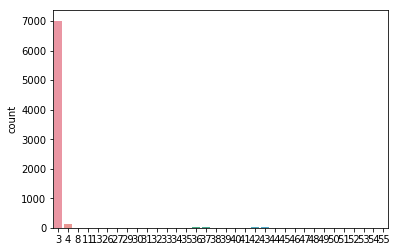

Minimum annotations in a example:  3
Maximum annotations in a example:  55
T data (expected value):  3.9093387866394003
Graphics of T weights


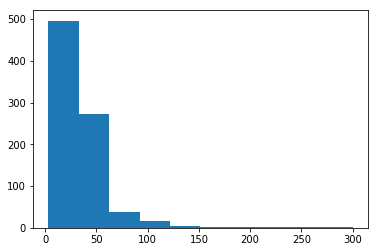

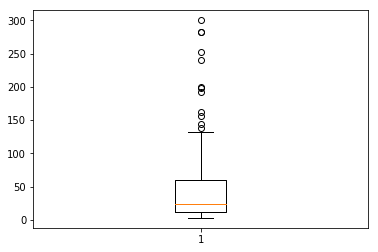

Minimum annotations by an annotator:  3
Maximum annotations by an annotator:  300
Mean annotations by an annotator:  34.25925925925926


In [96]:
#graphics and distribution? what is T_data
T_weights = np.sum(y_obs != -1,axis=0) #distribucion de anotaciones
N_ann = np.sum(y_obs != -1,axis=1) #distribucion de anotaciones con este valor

N, T = y_obs.shape
Kl = np.max(y_obs)+1

sns.countplot(N_ann)
plt.show()
print("Minimum annotations in a example: ",N_ann.min())
print("Maximum annotations in a example: ",N_ann.max())
print("T data (expected value): ",N_ann.mean())

print("Graphics of T weights")
plt.hist(T_weights)
plt.show()

plt.boxplot(T_weights)
plt.show()
print("Minimum annotations by an annotator: ",T_weights.min())
print("Maximum annotations by an annotator: ",T_weights.max())
print("Mean annotations by an annotator: ",T_weights.mean())

Representation for MV in 0.291999 sec
Estimation MV in 0.000844 sec
Normalized entropy (0-1) of repeats annotations: 0.1748801127837196


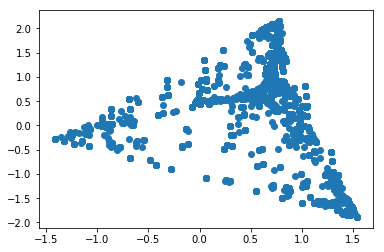

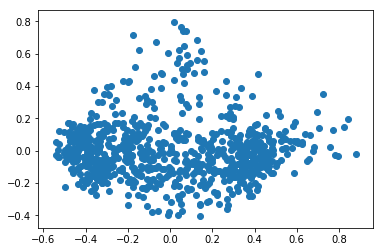

In [97]:
from sklearn.metrics import f1_score
label_I = LabelInference(y_obs,1,type_inf = 'mv')
mv_onehot, conf = label_I.mv_labels('classes')
#print("ACC MV on train:",np.mean(mv_onehot==Z_data))
#print("F1 MV on train:",f1_score(Z_data,mv_onehot,average="micro"))


mv_soft = majority_voting(label_I.y_obs_repeat,repeats=True,probas=True) 
aux = []
for example in mv_soft:
    aux.append(entropy(example)/np.log(Kl))
print("Normalized entropy (0-1) of repeats annotations:",np.mean(aux))

predicted = np.clip(mv_soft, keras.backend.epsilon(), 1.)
data_to_cluster = []
for i in range(mv_soft.shape[0]):
    for j in range(mv_soft.shape[1]):
        ob = np.tile(keras.backend.epsilon(), mv_soft.shape[1])
        ob[j] = 1
        true = np.clip(predicted[i],keras.backend.epsilon(),1.)      
        f_l = distance_function(true, ob)  #funcion de distancia o similaridad
        data_to_cluster.append(f_l)  
data_to_cluster = np.asarray(data_to_cluster)
model = PCA(n_components=min(3,mv_soft.shape[1]) ) 
data_to_cluster = model.fit_transform(data_to_cluster)

std = StandardScaler(with_mean=True,with_std=True)
data_to_plot = std.fit_transform(data_to_cluster)
plt.scatter(data_to_plot[:,0],data_to_plot[:,1])
plt.show()


Y_ann_train, T_idx = set_representation(y_obs,"onehotvar")
from code.MixtureofGroups import *
conf_mat, conf_mat_norm  = build_conf_Yvar(Y_ann_train, T_idx, mv_soft.argmax(axis=-1))

A_rep = conf_mat_norm.reshape(conf_mat_norm.shape[0], Kl**2) #flatten

from sklearn.decomposition import PCA
model = PCA(2)
aux_pca = model.fit_transform(A_rep)
plt.scatter(aux_pca[:,0],aux_pca[:,1])
plt.show()

### Texto

In [184]:
folder = "../Nuevos/TEXTO/pcbi.1000391.s002/annotation-data/"
from scipy.io import loadmat
ann = loadmat(folder+"patterns8.mat")
ann

{'E': array([[ 4,  2,  1, ..., -1, -1, -1],
        [ 4,  2,  1, ..., -1, -1, -1],
        [ 3,  3,  3, ..., -1, -1, -1],
        ...,
        [ 3,  3, -1, ..., -1, -1,  3],
        [ 1,  3, -1, ..., -1, -1,  3],
        [ 4,  3, -1, ..., -1, -1,  3]], dtype=int16),
 'Ep': array([[219, 406, 177, 320, 285, 203, 206, 222],
        [  6, 148,   9,  93,   3,  80, 200, 161],
        [  1,   4,   2,  14,   6,  14,   6,   8],
        [ 38,  48,  13,  37,   8,  40, 101,  78],
        [  9,   8,   0,   0,   0,   0,   0,   0],
        [118,   3, 273,  15, 331,   5,   2,   0],
        [  9,  17,  31,  10,  17,   0,  11,   0],
        [  1,   2,   9,   2,   5,   2,   2,   0],
        [ 18,   2,  47,   3,  18,   0,   1,   1],
        [  2,   0,   0,   0,   0,   0,   0,   0],
        [  3,  11,   3,   2,  21,   5,   1,   0],
        [  0,   3,   0,   5,  21,   0,   0,   2],
        [  9,  31,  15,   7,  19,   6,   5,   8],
        [  1,   3,   3,   1,   2,   0,   0,   5],
        [  0,   1,   0,   0

In [191]:
y_obs = ann["F"]
y_obs

array([[ 4,  4,  4, ..., -1, -1, -1],
       [ 4,  4,  4, ..., -1, -1, -1],
       [ 4,  4,  4, ..., -1, -1, -1],
       ...,
       [ 4,  1, -1, ..., -1, -1,  4],
       [ 1,  4, -1, ..., -1, -1,  4],
       [ 4,  4, -1, ..., -1, -1,  4]], dtype=int16)

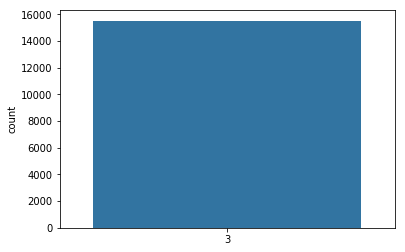

Minimum annotations in a example:  3
Maximum annotations in a example:  3
T data (expected value):  3.0
Graphics of T weights


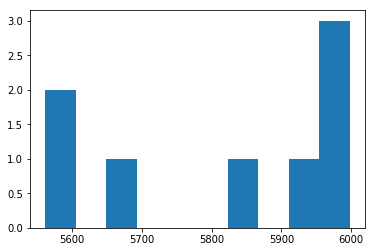

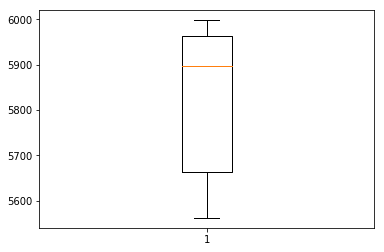

Minimum annotations by an annotator:  5562
Maximum annotations by an annotator:  5998
Mean annotations by an annotator:  5820.375


In [192]:
#graphics and distribution? what is T_data
T_weights = np.sum(y_obs != -1,axis=0) #distribucion de anotaciones
N_ann = np.sum(y_obs != -1,axis=1) #distribucion de anotaciones con este valor

N, T = y_obs.shape
Kl = np.max(y_obs)+1

sns.countplot(N_ann)
plt.show()
print("Minimum annotations in a example: ",N_ann.min())
print("Maximum annotations in a example: ",N_ann.max())
print("T data (expected value): ",N_ann.mean())

print("Graphics of T weights")
plt.hist(T_weights)
plt.show()

plt.boxplot(T_weights)
plt.show()
print("Minimum annotations by an annotator: ",T_weights.min())
print("Maximum annotations by an annotator: ",T_weights.max())
print("Mean annotations by an annotator: ",T_weights.mean())